In [1]:
print("Hello, Jupyter!")

Hello, Jupyter!


In [1]:
# Show figures inline
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import matplotlib.colors as colors
from meshoid import Meshoid
import utils_data as my
# Auto reload packages
%load_ext autoreload
%autoreload 2
# Use plot style
plt.style.use('./niceplot2jay.mplstyle')

In [2]:
# Load the file
# file = '/appalachia/d6/yujie/tmp/snapshot_600.hdf5'
# file = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_659.hdf5'
file = './data/snapshot_659_9.hdf5'
f = h5py.File(file, 'r')

In [3]:
# Load the data
rho = f["PartType0"]["Density"][:]
pos = f["PartType0"]["Coordinates"][:]
mass = f["PartType0"]["Masses"][:]
v = f["PartType0"]["Velocities"][:]
u = f['PartType0/InternalEnergy'][:]
xe = f['PartType0/ElectronAbundance'][:]
f.close()

In [4]:
# Initialize
res = 512 # resolution
xmin, xmax = np.min(pos[:,0]), np.max(pos[:,0])
ymin, ymax = np.min(pos[:,1]), np.max(pos[:,1])
# Grid
xgrid = np.linspace(xmin, xmax, res)
ygrid = np.linspace(ymin, ymax, res)
X, Y = np.meshgrid(xgrid, ygrid)
# Center
xcenter, ycenter = (xmax - xmin)/2 + xmin, (ymax - ymin)/2 + ymin
center = np.array([xcenter, ycenter, 300])
print(center)
# Create meshoid object
M = Meshoid(pos, mass)

[308.2530456  297.90483835 300.        ]


## Plots

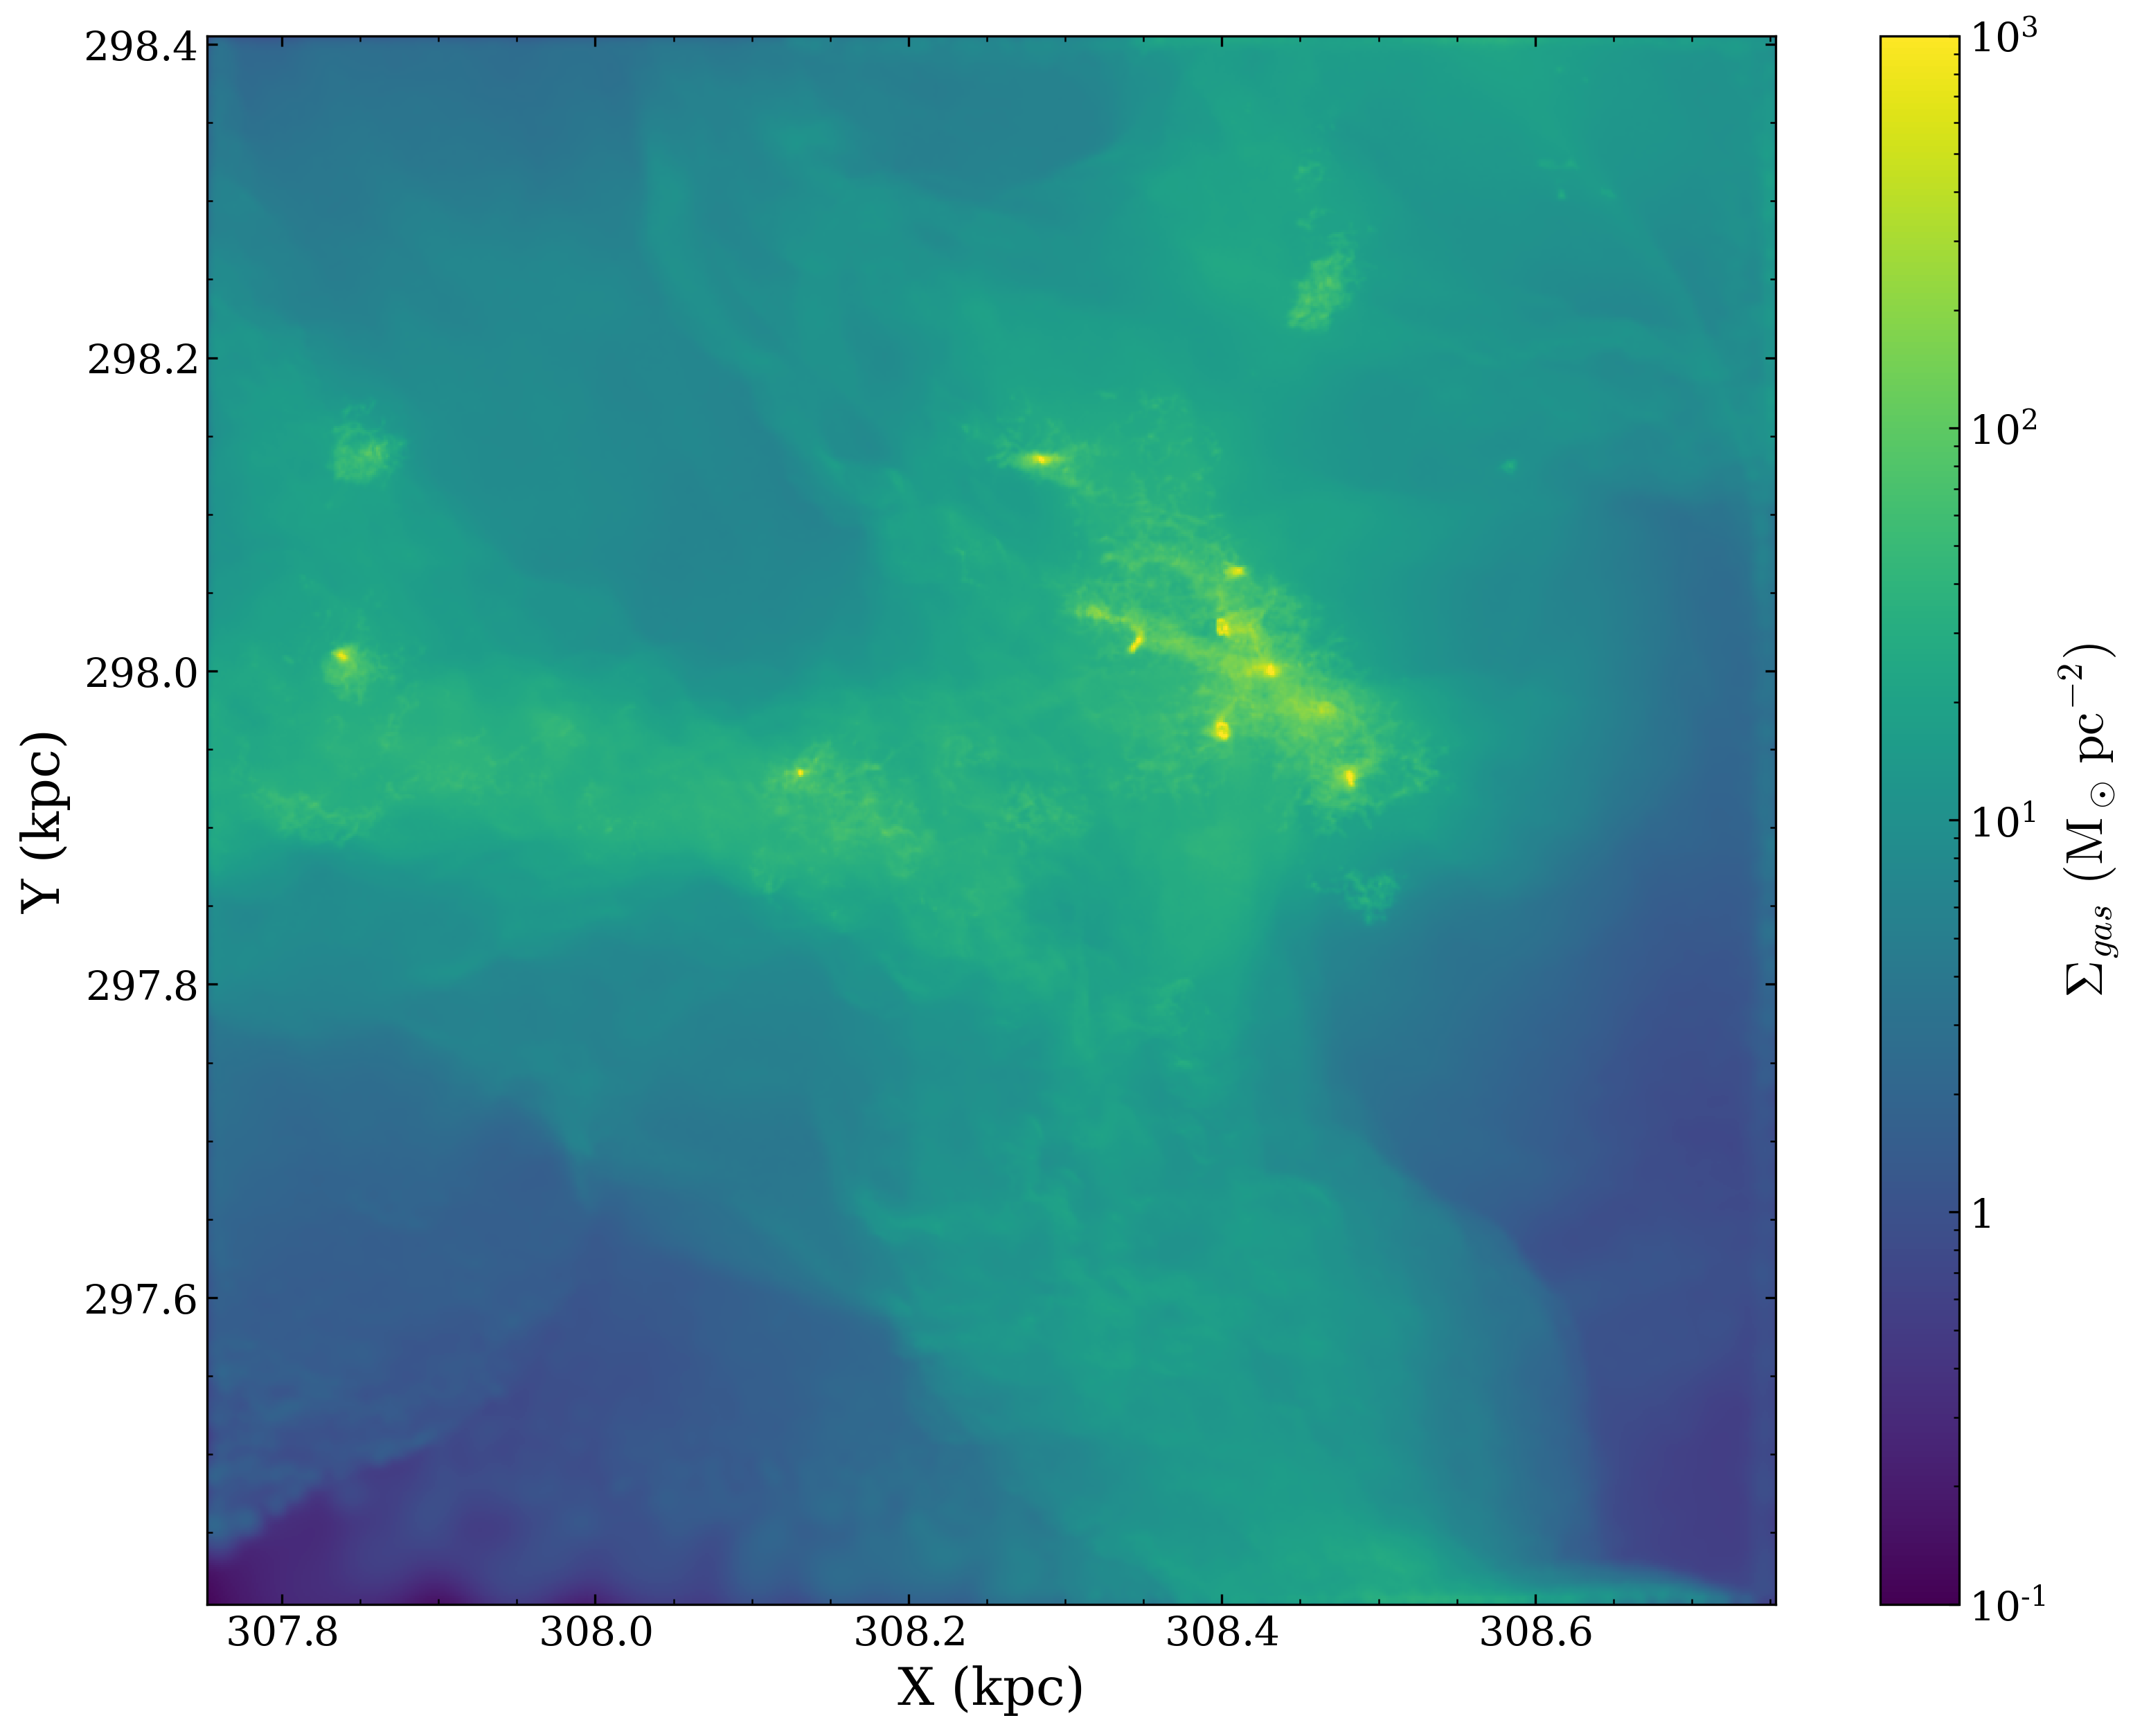

In [6]:
# Density Projection Plot
fig, ax = plt.subplots(figsize=(13,10))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=center[:2],size=1.,res=res)*1e4
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$\Sigma_{gas}$ $(\rm M_\odot\,pc^{-2})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

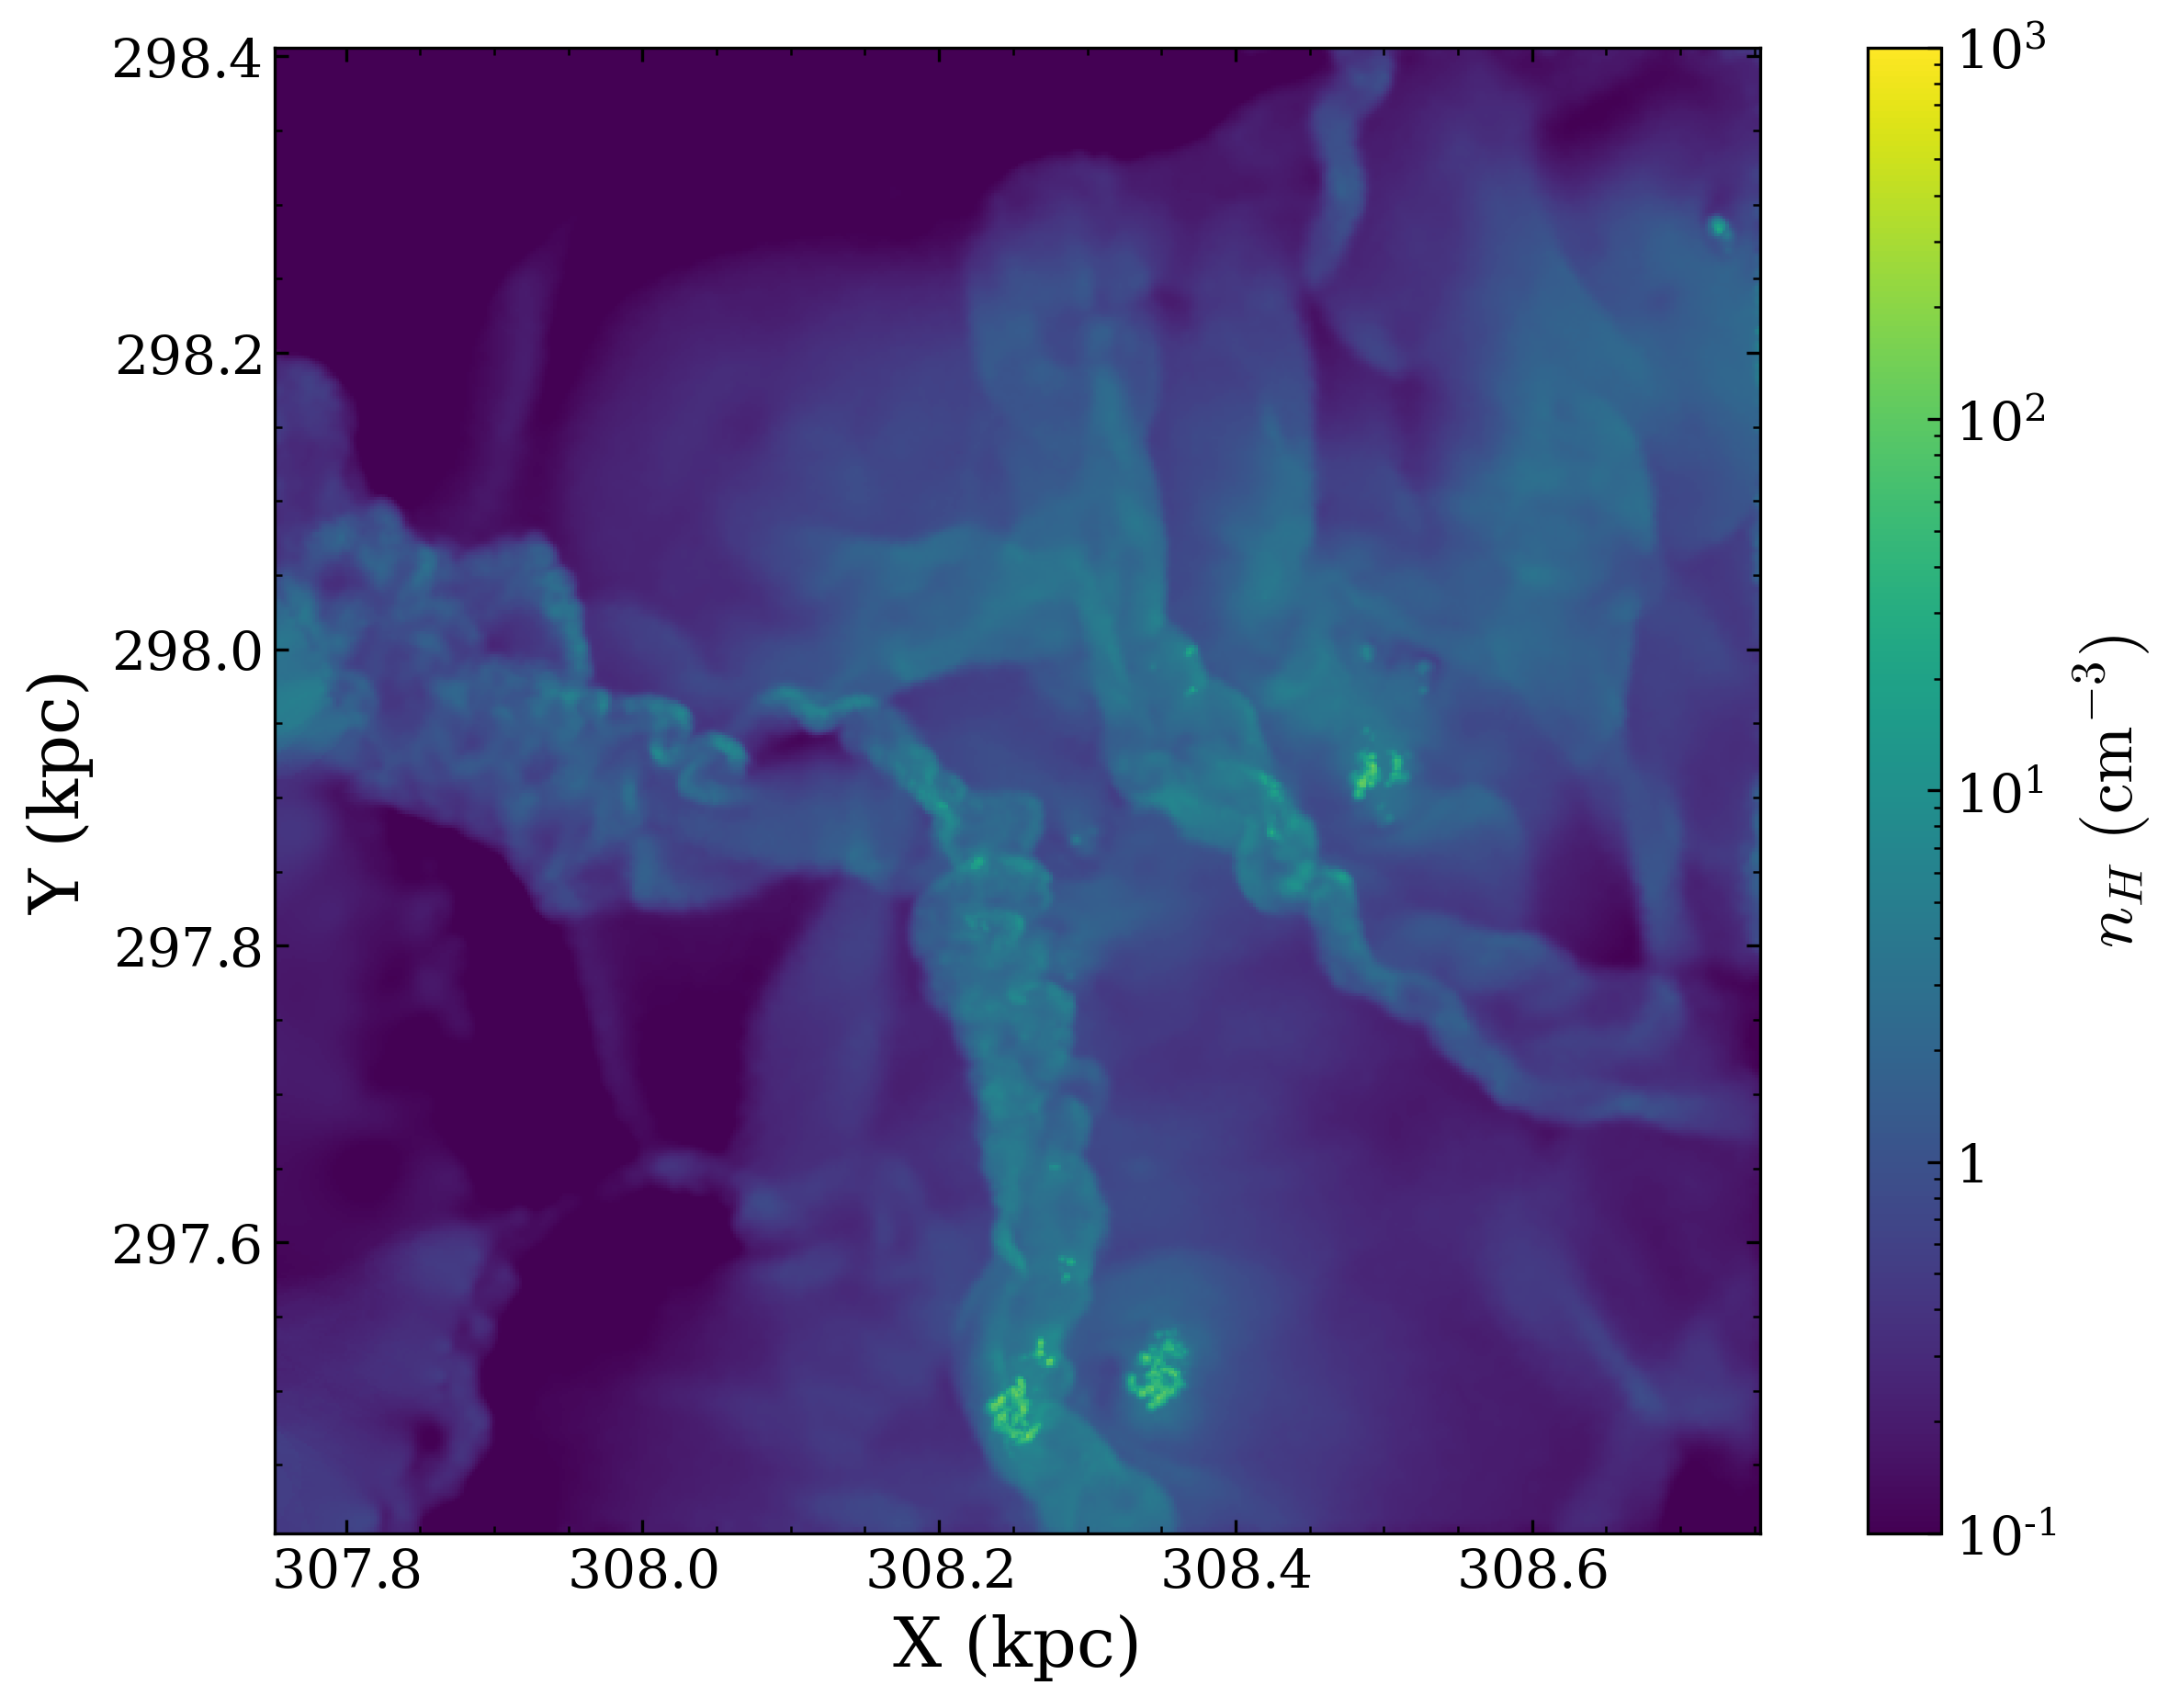

In [8]:
# Density Map
# Slice
density_slice_nHcgs = M.Slice(M.Density(),center=center,res=res,size=1.) * 300
# Plot
fig, ax = plt.subplots(figsize=(10,7))
p = ax.pcolormesh(X, Y, density_slice_nHcgs, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$n_H$ $(\rm cm^{-3})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

The FFT\filter operations are done on slices instead of cubes, which could be problematic. - Project all particles onto a cube?

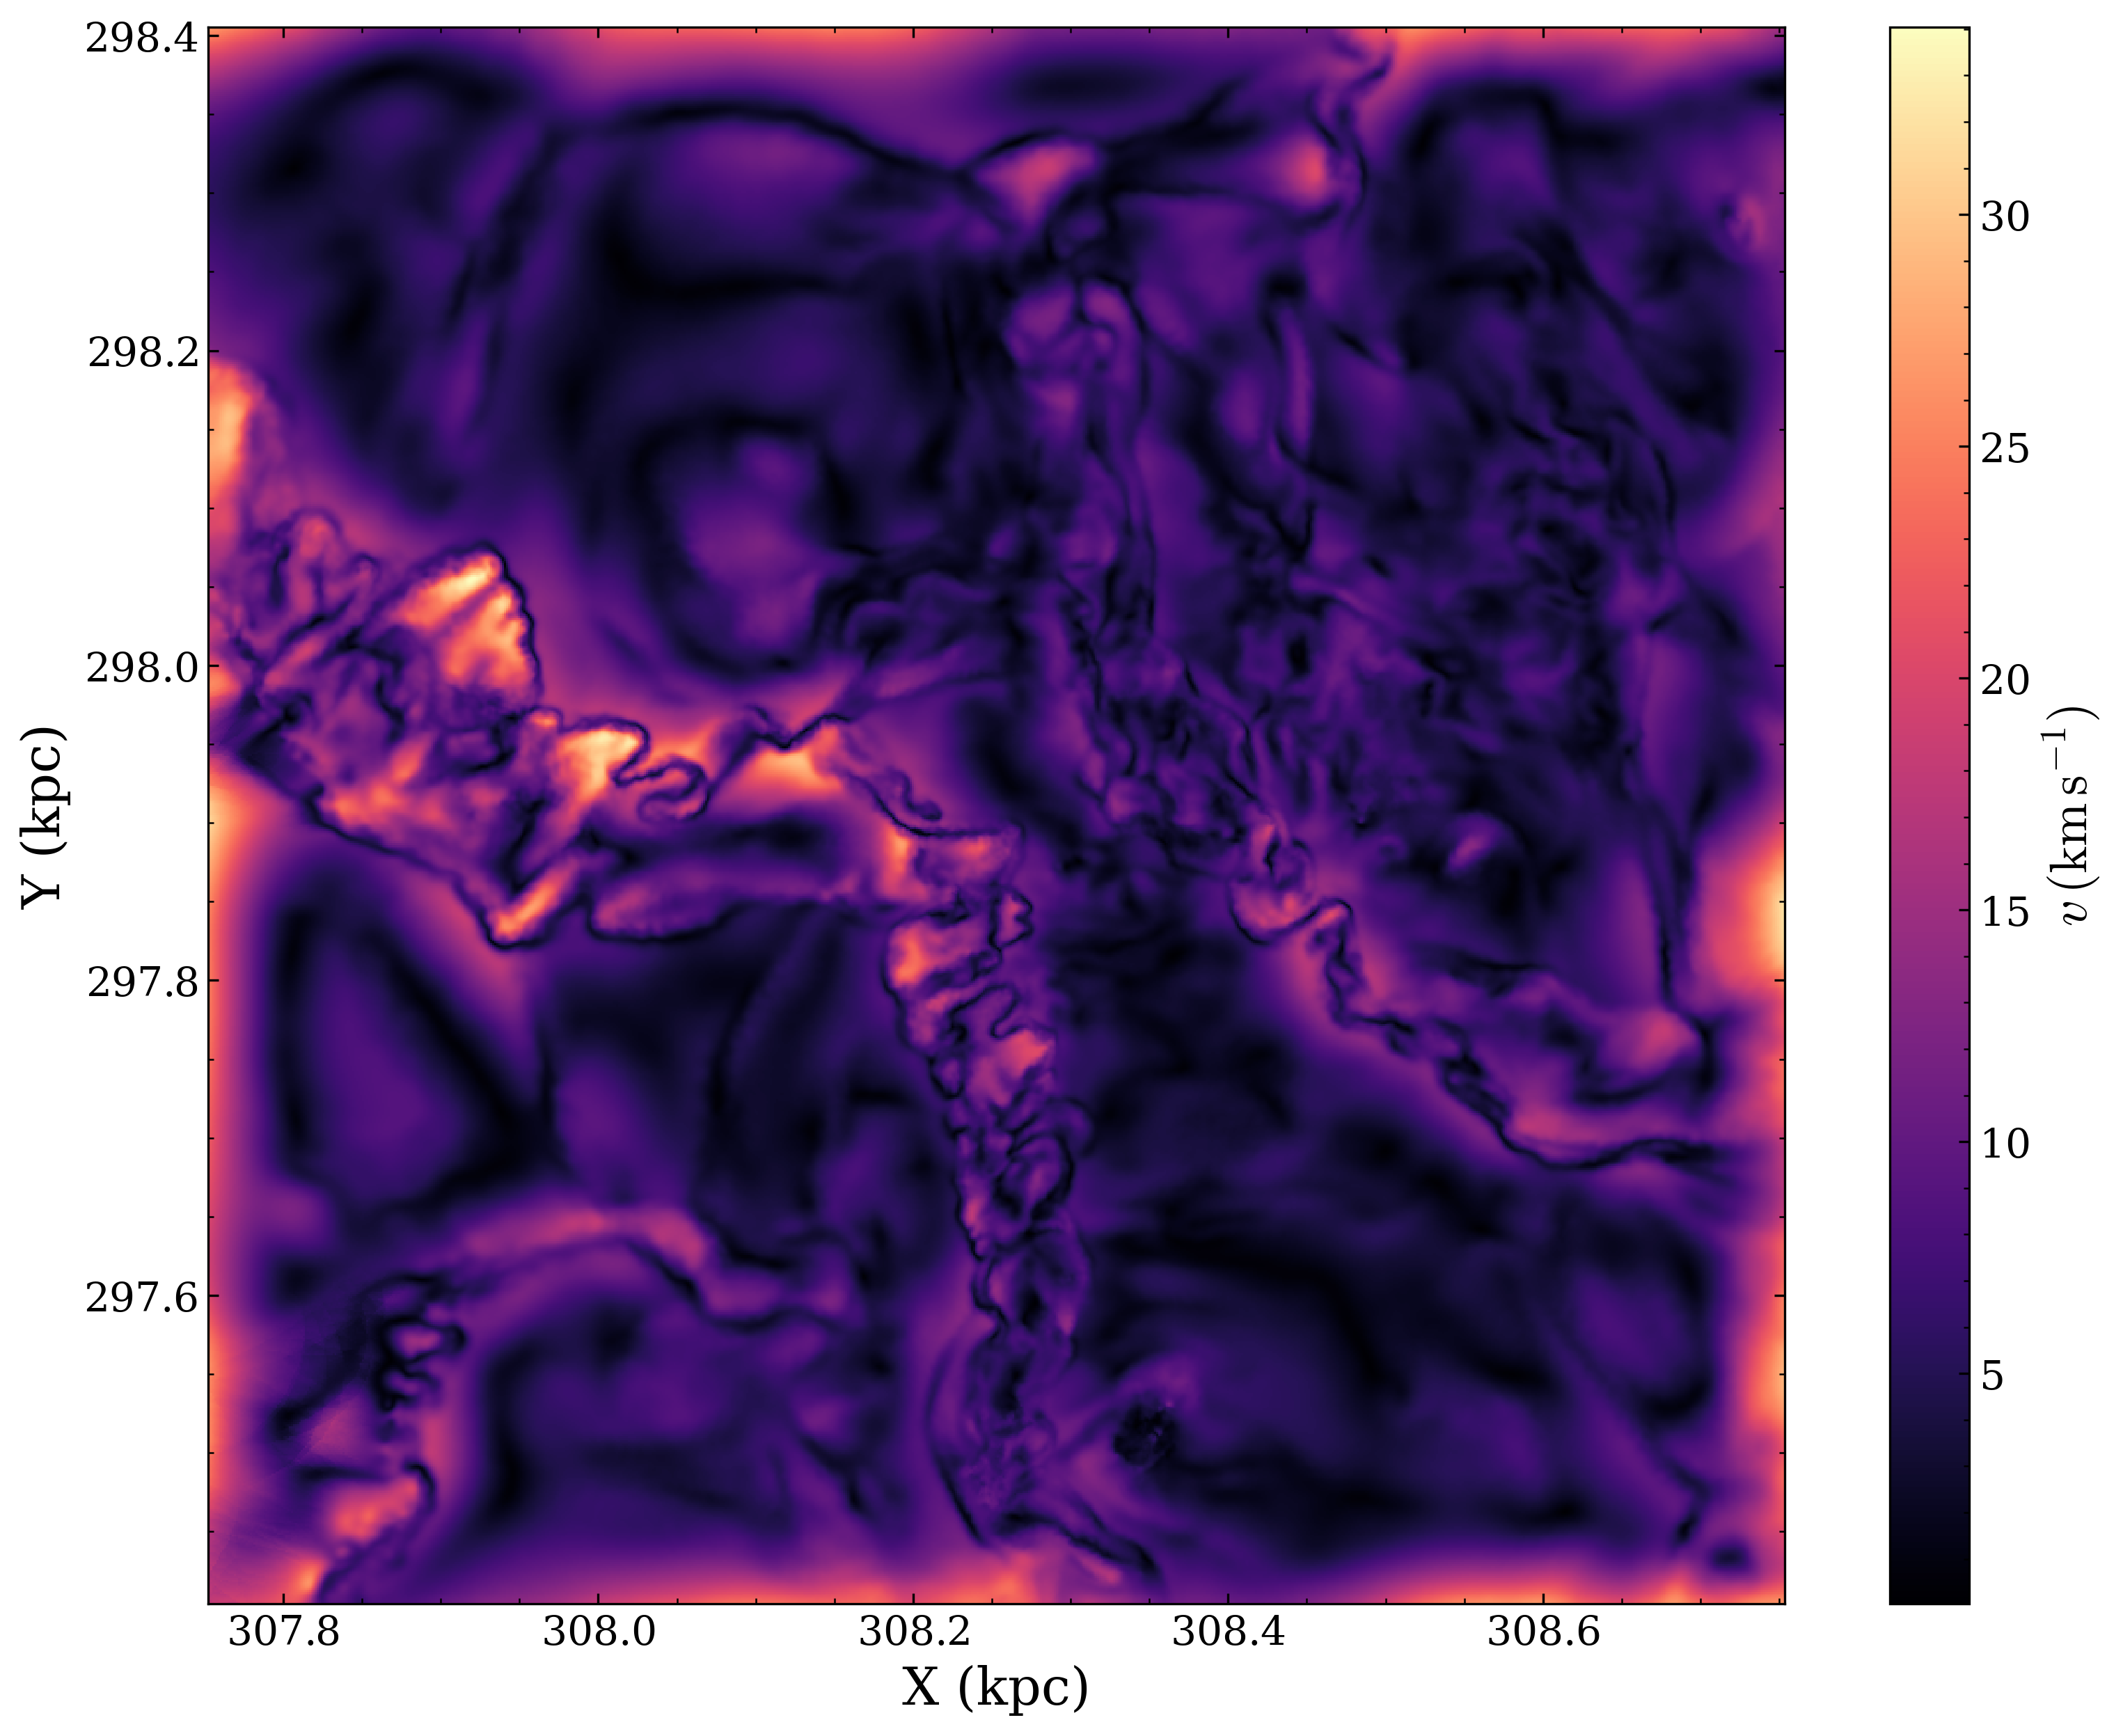

In [10]:
# Turbulence Speed Map # Mass weighted # k filter
vx_slice = M.Slice(v[:,0],center=center,res=res,size=1.)
vy_slice = M.Slice(v[:,1],center=center,res=res,size=1.)
vz_slice = M.Slice(v[:,2],center=center,res=res,size=1.)

vfield = np.array([vx_slice,vy_slice,vz_slice])
vfield_turb = np.zeros(np.shape(vfield))

for i in [0,1,2]:
    # FFT
    vkifield = np.fft.fftn(vfield[i], norm='ortho')
    shifted = np.fft.fftshift(vkifield)
    # Filter out small k (large scale)
    filtered = my.circle_kbin2d(shifted, Lbox=1, low_k=2*np.pi/0.2) # Bin to the lowest frequency
    # Inverse FFT
    vkifield_filtered = np.fft.ifftshift(filtered)
    vifield_filtered = np.real(np.fft.ifftn(vkifield_filtered, norm='ortho'))

    vfield_turb[i] = vifield_filtered
vvfield_kms = (vfield_turb[0]**2 + vfield_turb[1]**2 + vfield_turb[2]**2)**0.5

# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, vvfield_kms, cmap='magma')
ax.set_aspect('equal')
fig.colorbar(p,label=r"$v \, (\rm km\,s^{-1})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

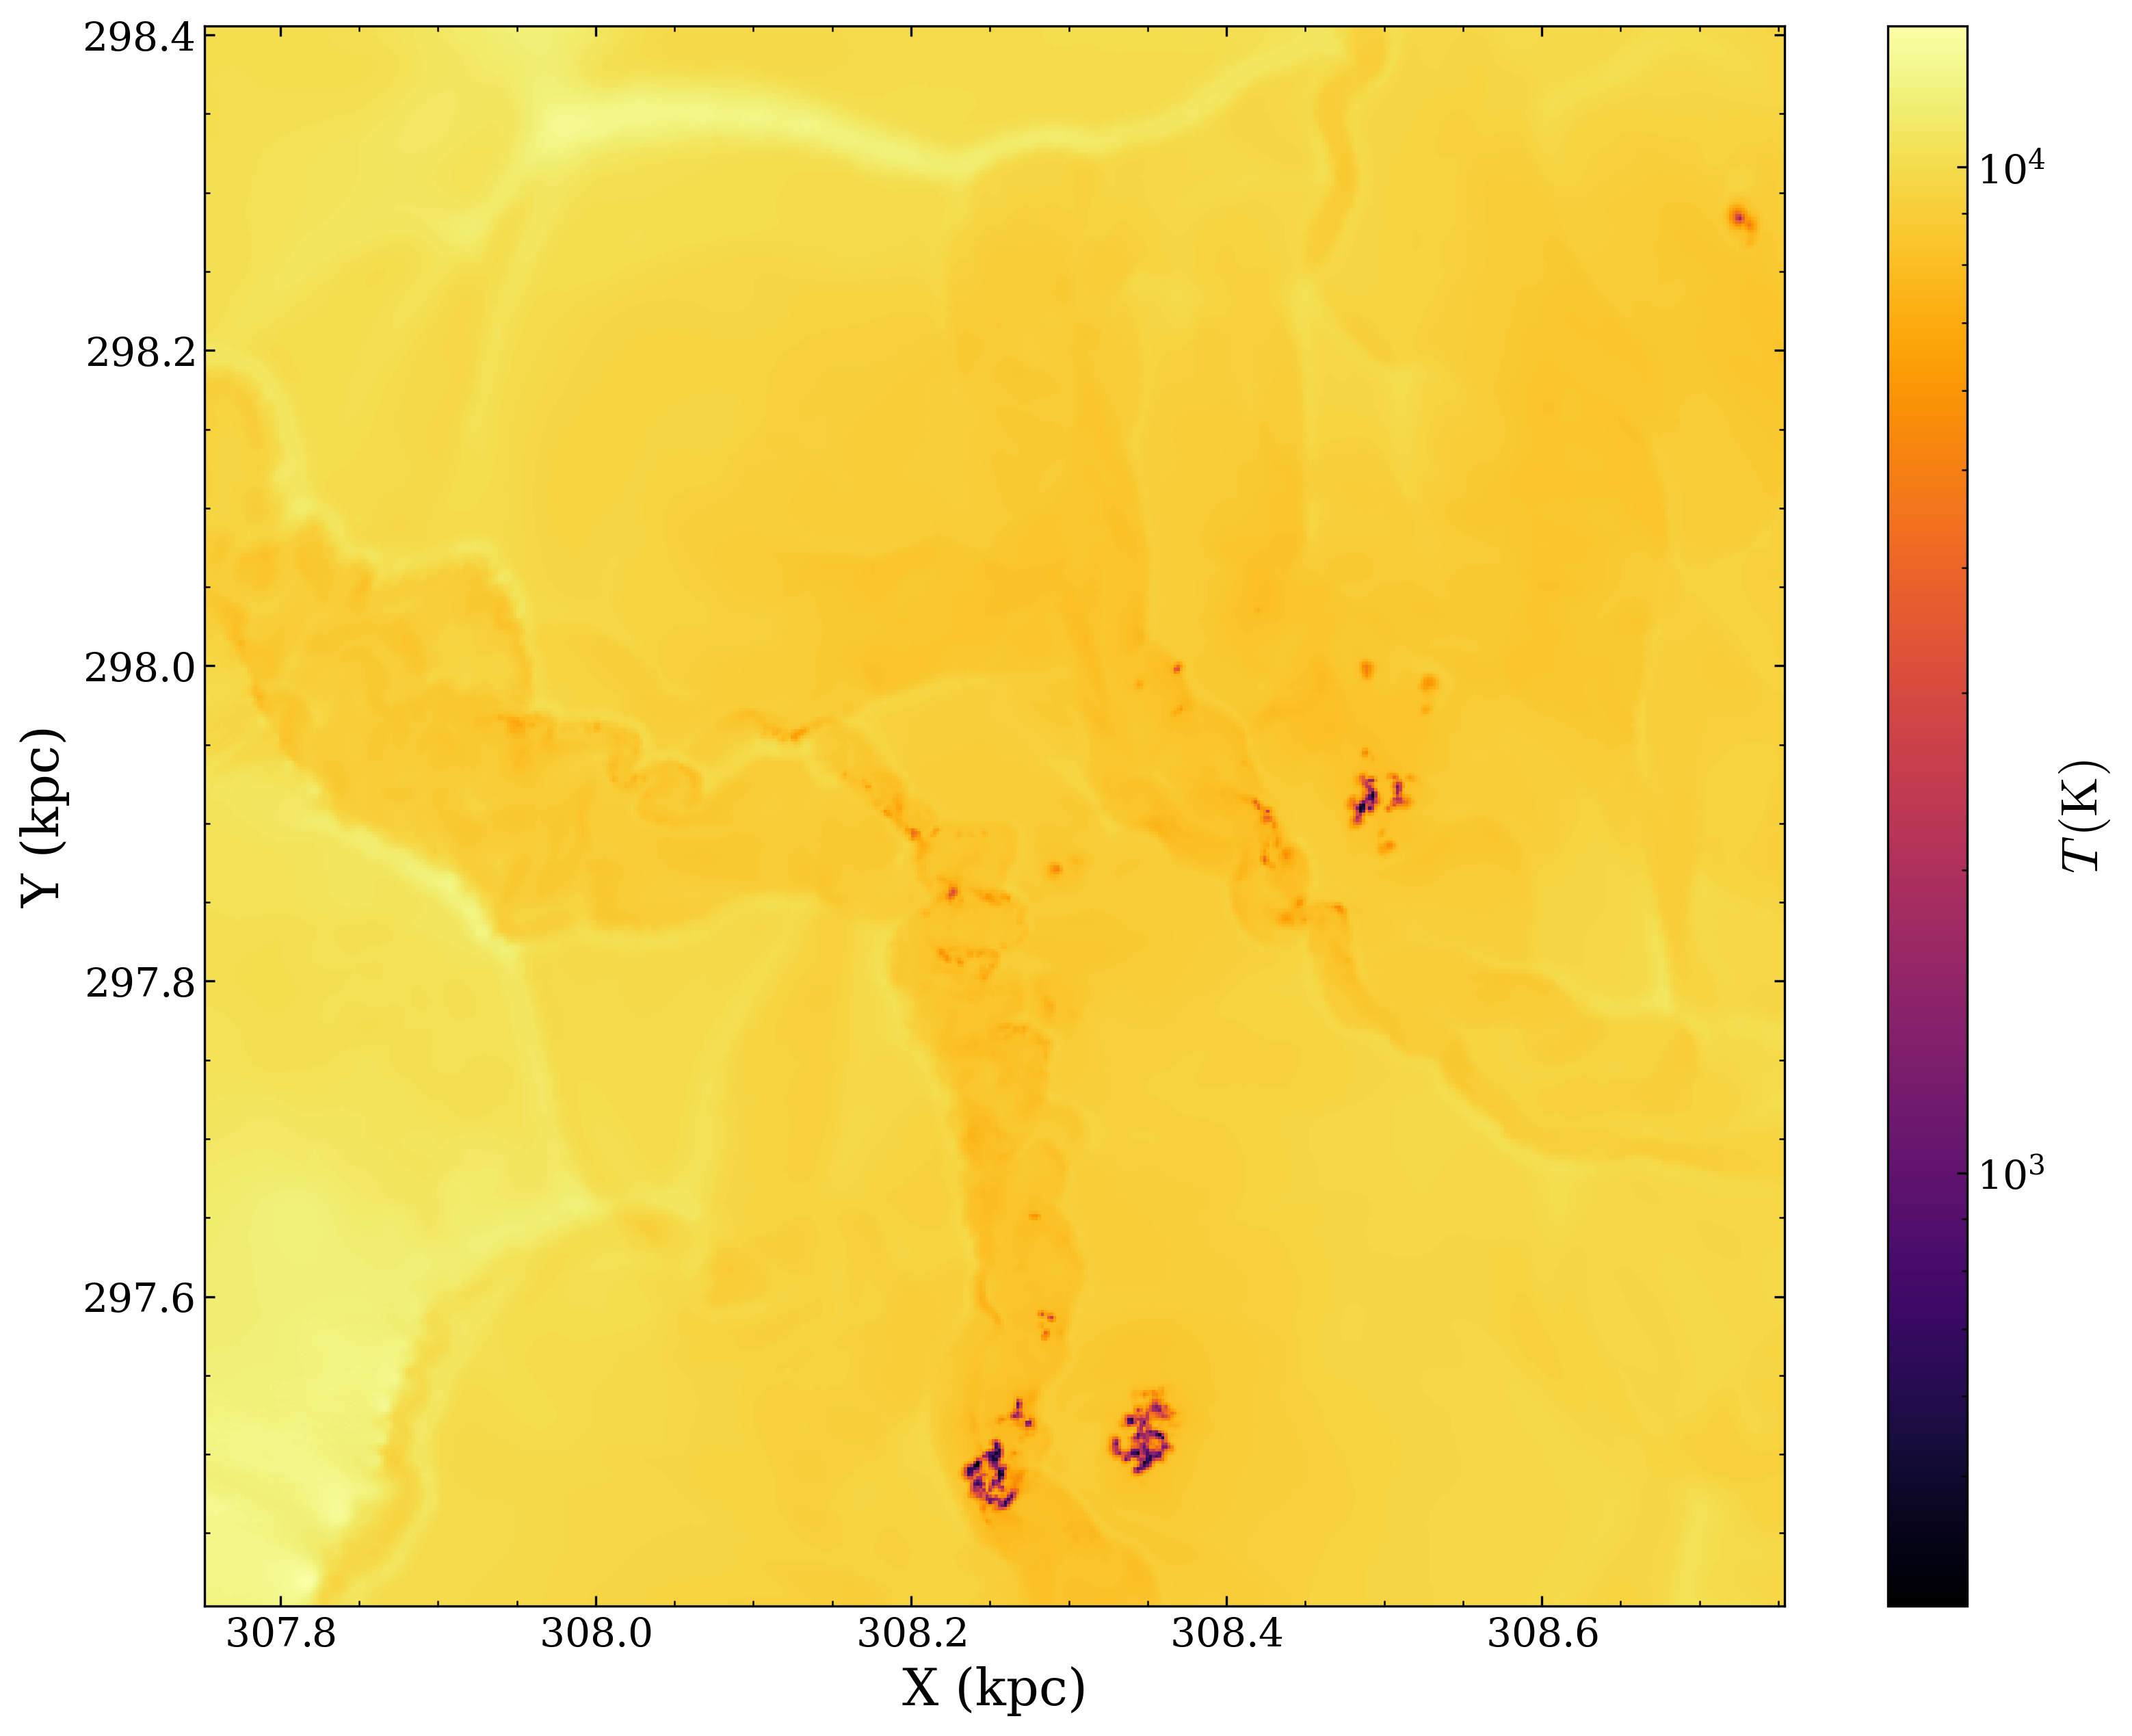

In [5]:
# Temperature
XH = 0.76
mp = 1.67e-24
gamma = 5/3
kb = 1.38e-16
mu = 4/(1 + 3*XH + 4*XH*xe) * mp
T = (gamma - 1)*u/kb * 10**10 * mu
# Slice
T_K = M.Slice(T,center=center,res=res,size=1.)
# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, T_K, cmap='inferno',norm=colors.LogNorm())
ax.set_aspect('equal')
fig.colorbar(p,label=r"$T \, (\rm K)$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

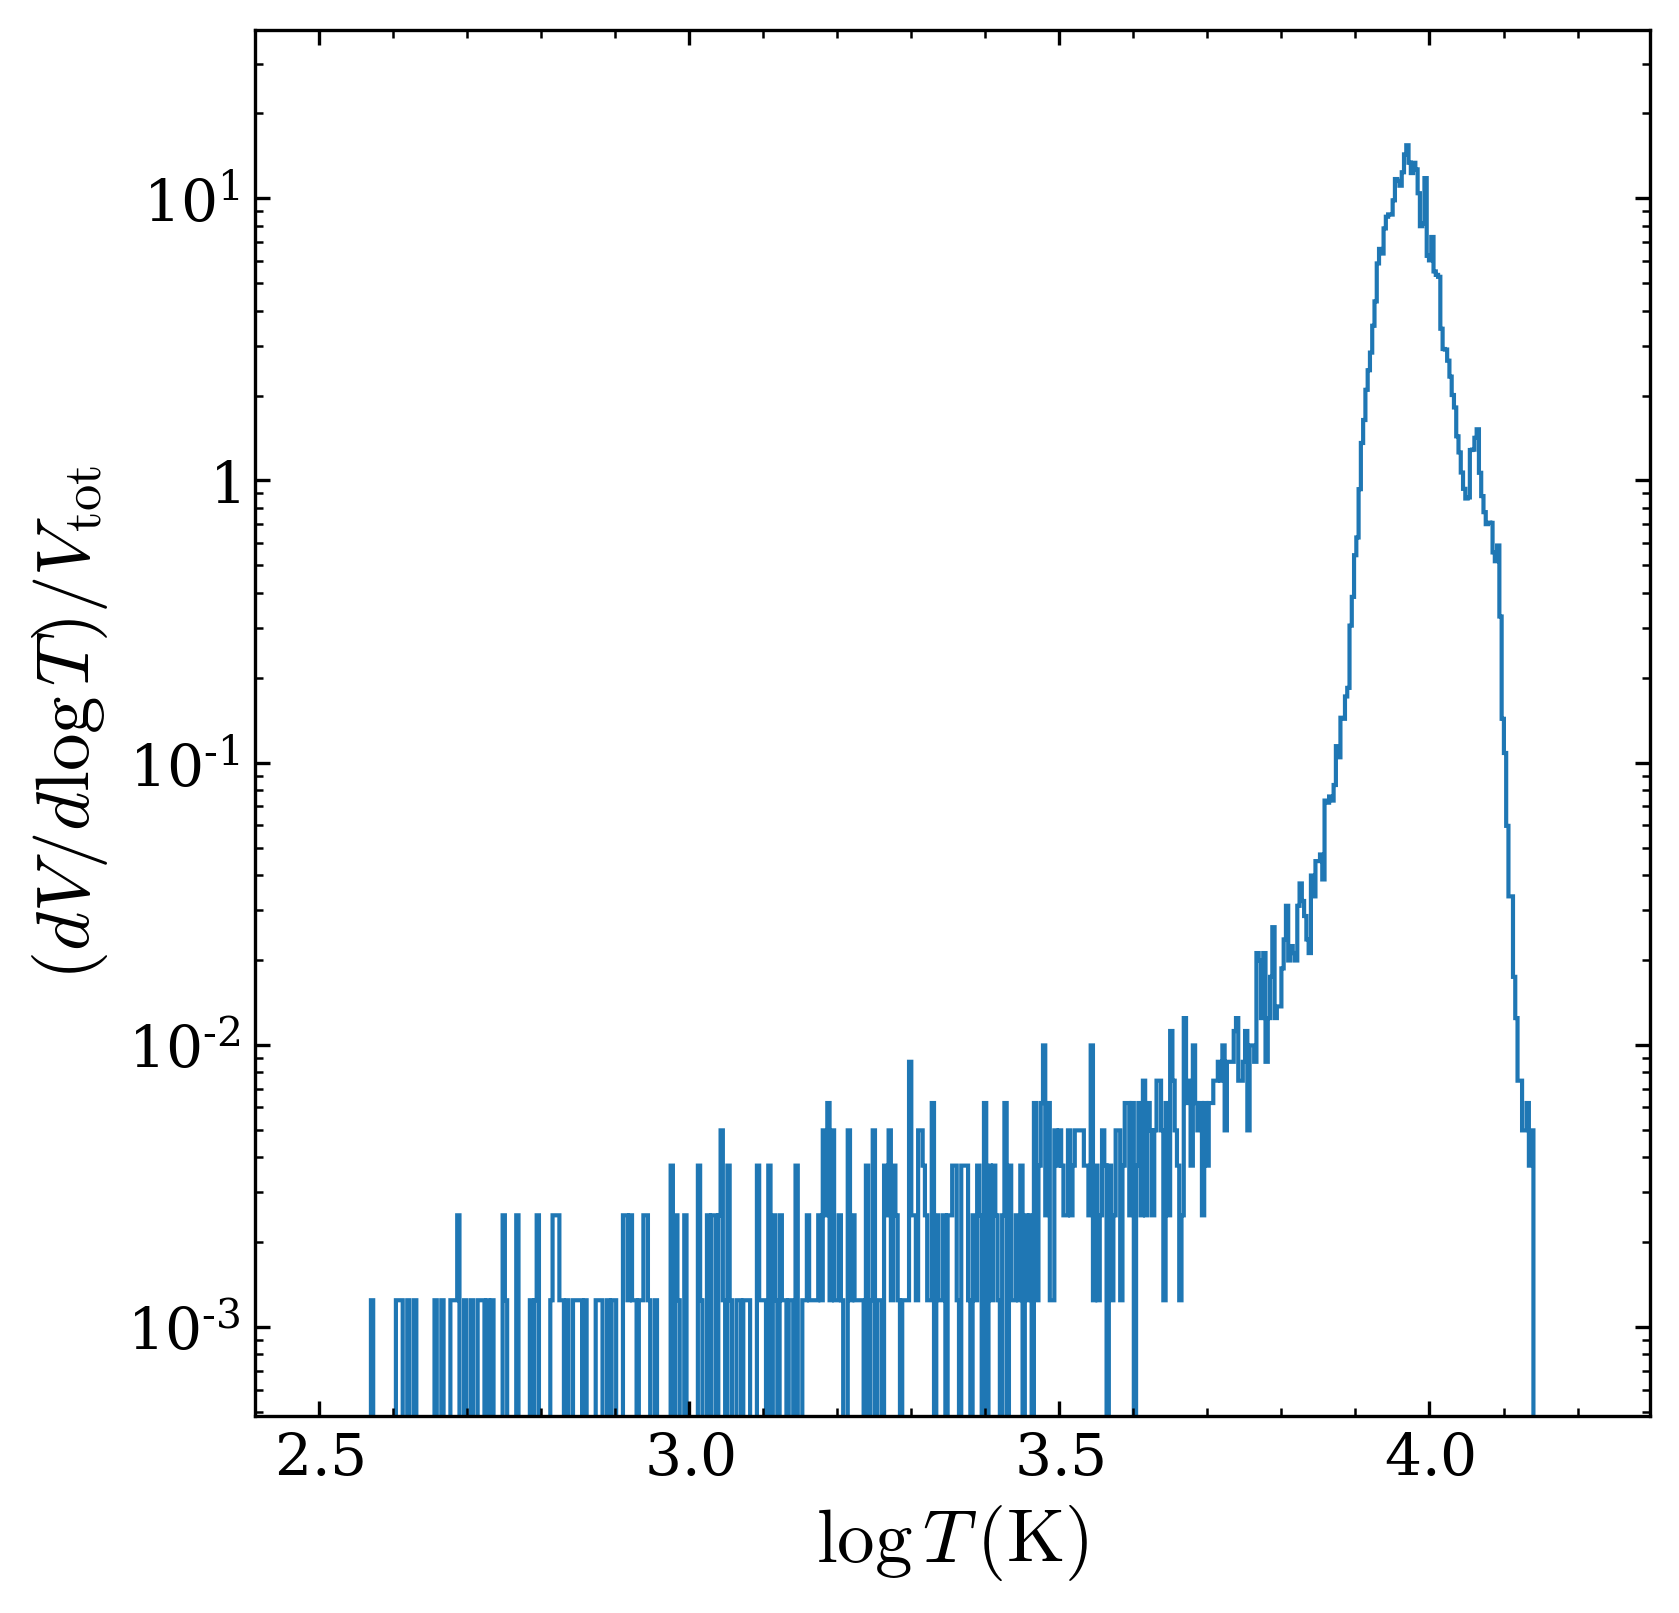

In [6]:
# PDF of interpolated Temperature, for comparison to voxelize
plt.hist(np.log10(np.ravel(T_K)), bins=512, density=True, histtype='step', log=True)
plt.xlabel('$\log{T} \, \mathrm{(K)}$')
plt.ylabel('$(dV/d\log{T})/V_\mathrm{tot}$')
# plt.title('Temperature PDF')
plt.show()

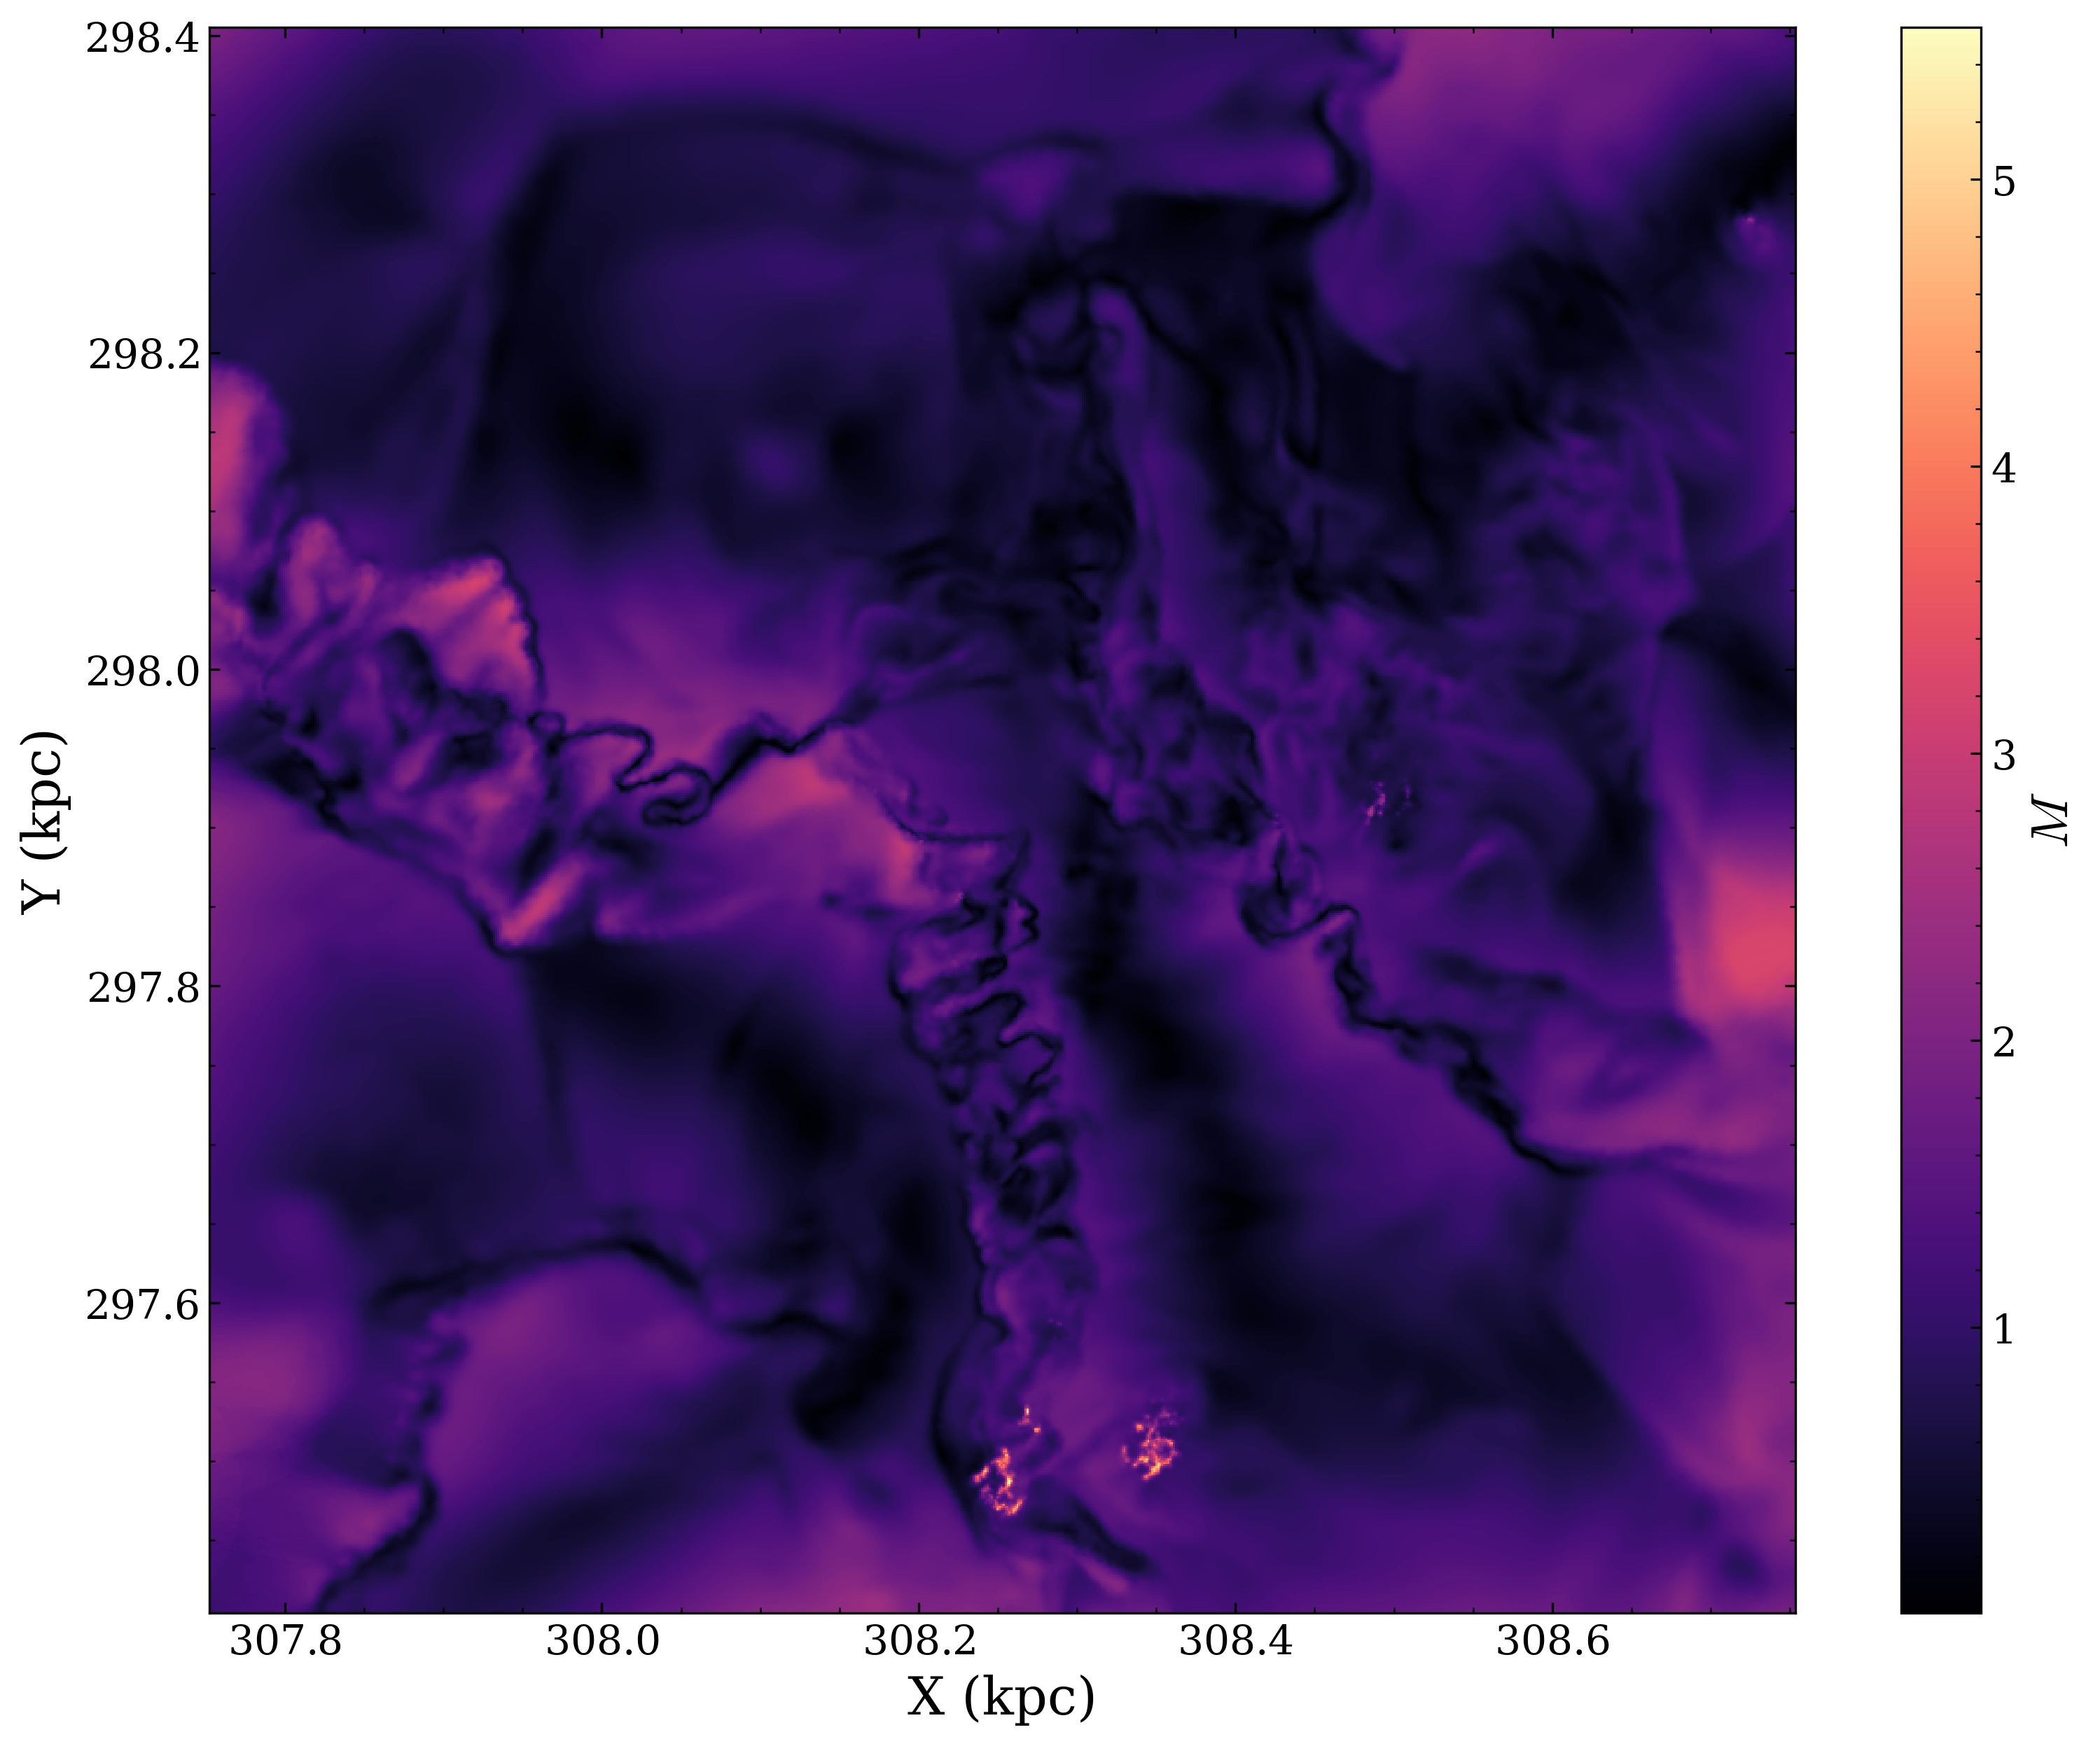

In [42]:
# Machnumber Map # k filter
vx_slice = M.Slice(v[:,0],center=center,res=res,size=1.)
vy_slice = M.Slice(v[:,1],center=center,res=res,size=1.)
vz_slice = M.Slice(v[:,2],center=center,res=res,size=1.)

vfield = np.array([vx_slice,vy_slice,vz_slice])
vfield_turb = np.zeros(np.shape(vfield))

for i in [0,1,2]:
    # FFT
    vkifield = np.fft.fftn(vfield[i], norm='ortho')
    shifted = np.fft.fftshift(vkifield)
    # Filter out small k (large scale)
    filtered = my.circle_bin2d(shifted, pixel_rad=2) # 2?3?4?5?
    # Inverse FFT
    vkifield_filtered = np.fft.ifftshift(filtered)
    vifield_filtered = np.real(np.fft.ifftn(vkifield_filtered, norm='ortho'))

    vfield_turb[i] = vifield_filtered
# Turbulence velocity field
vvfield_kms = (vfield_turb[0]**2 + vfield_turb[1]**2 + vfield_turb[2]**2)**0.5

XH = 0.76
mp = 1.67e-24
gamma = 5/3
kb = 1.38e-16
mu = 4/(1 + 3*XH + 4*XH*xe) * mp
T = (gamma - 1)*u/kb * 10**10 * mu
# Calculate soundspeed Cs
Cs = ((gamma * kb * T)/(mu))**0.5 / 10**5
# Sound speed field
Csfield_kms = M.Slice(Cs,center=center,res=res,size=1.)
# Mach number field
Machnumfield = vvfield_kms/Csfield_kms

# Visualize
fig, ax = plt.subplots(figsize=(13,10))
p = ax.pcolormesh(X, Y, Machnumfield, cmap='magma')
ax.set_aspect('equal')
fig.colorbar(p,label=r"$M$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

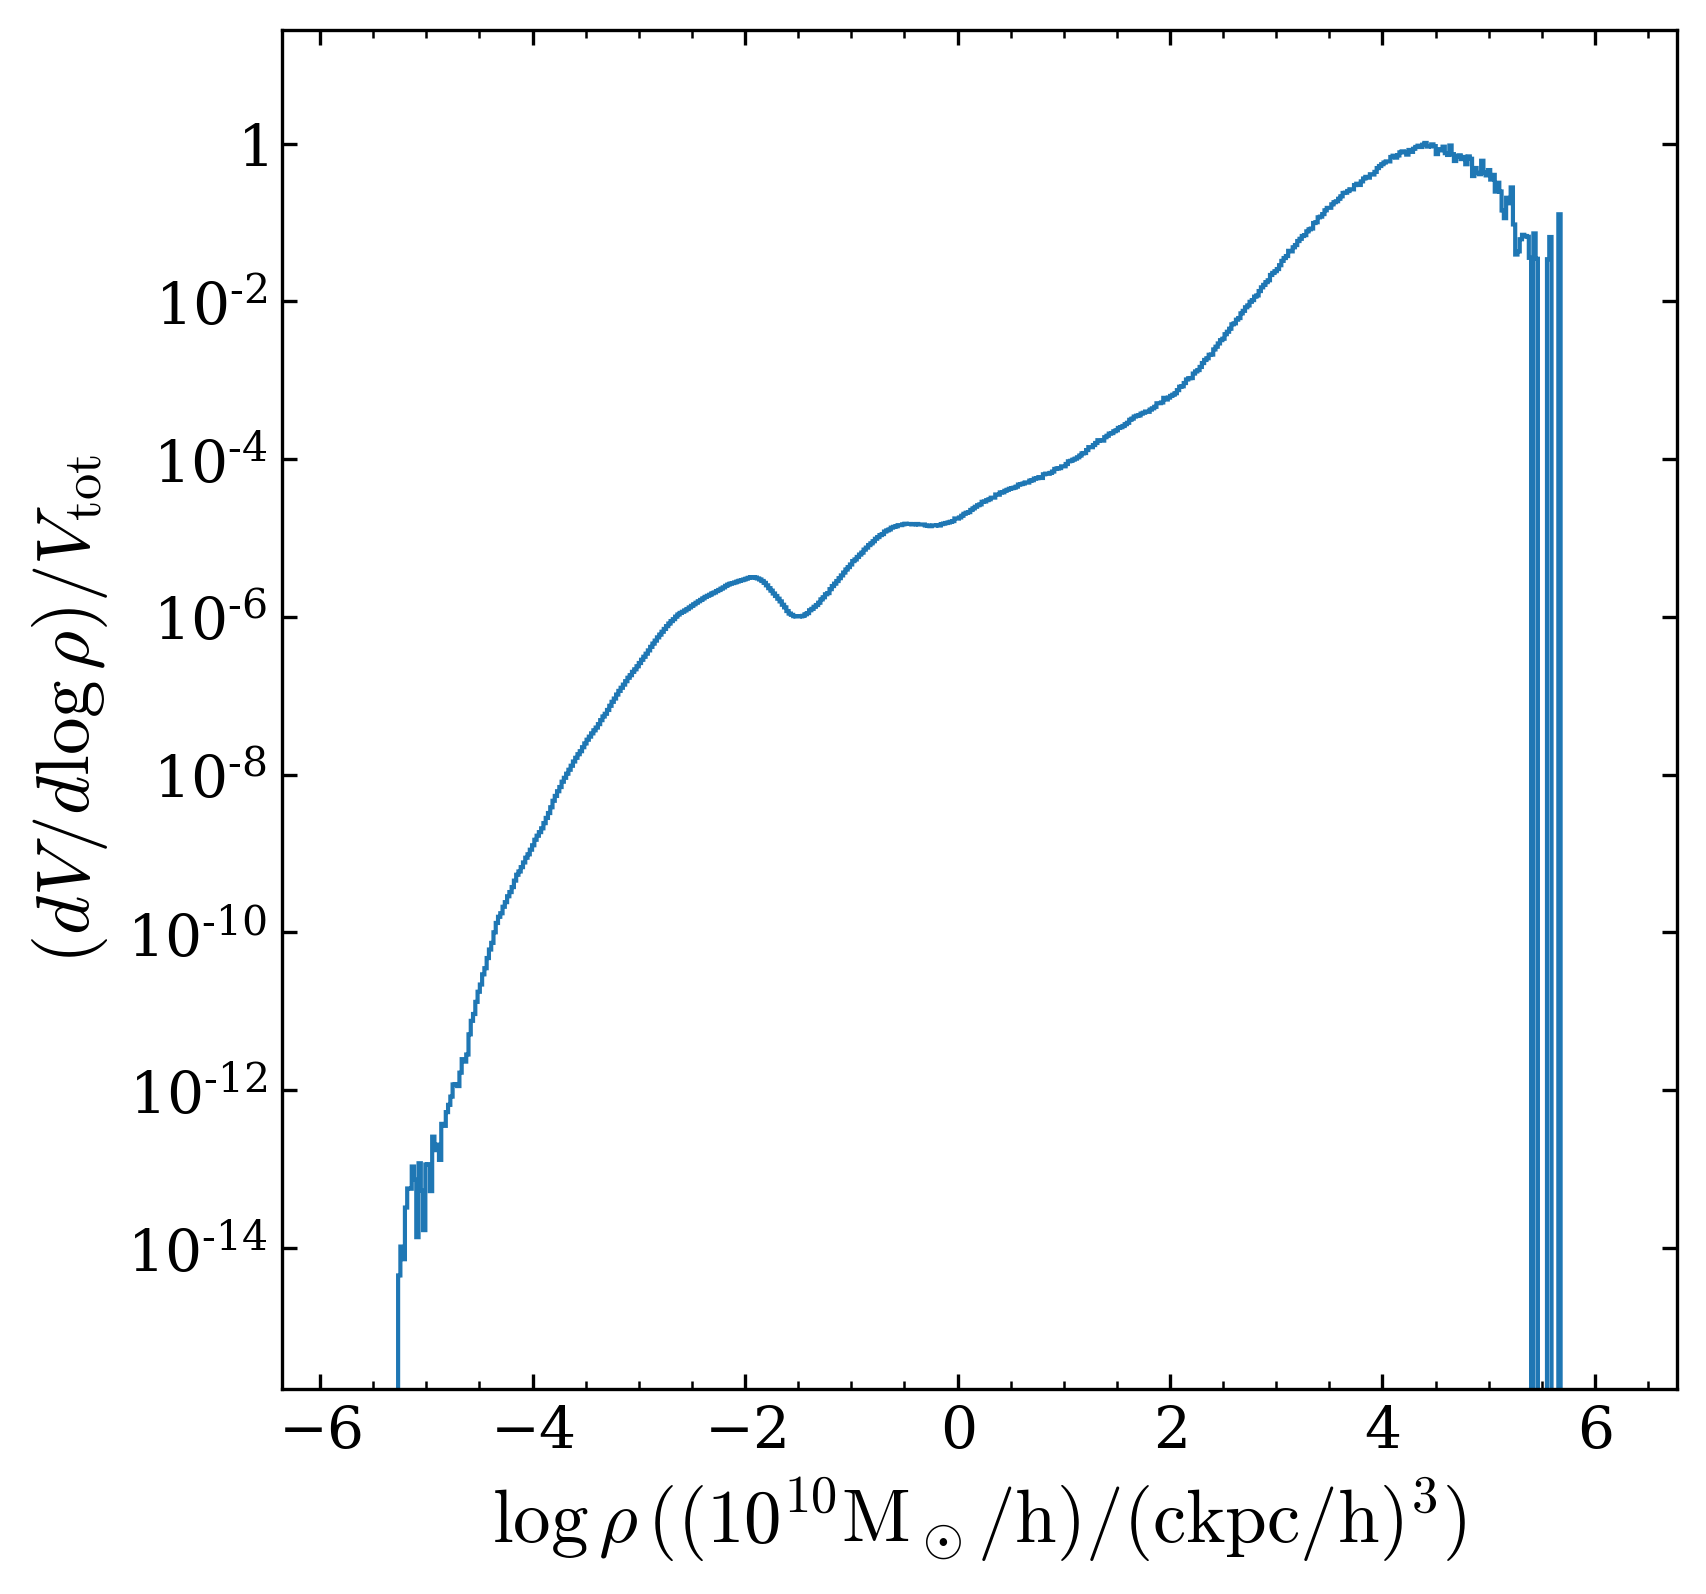

In [111]:
# Density PDF
rho = f['PartType0/Density'][()]
m = f['PartType0/Masses'][()]
V = rho/m
plt.hist(np.log10(rho), bins=512, density=True, histtype='step', weights=V, log=True)
plt.xlabel(r'$\log{\rho}\,\mathrm{(10^{10} M_\odot kpc^{-3})}$')
plt.ylabel(r'$(dV/d\log{\rho})/V_\mathrm{tot}$')
# plt.title('Density PDF')
plt.show()

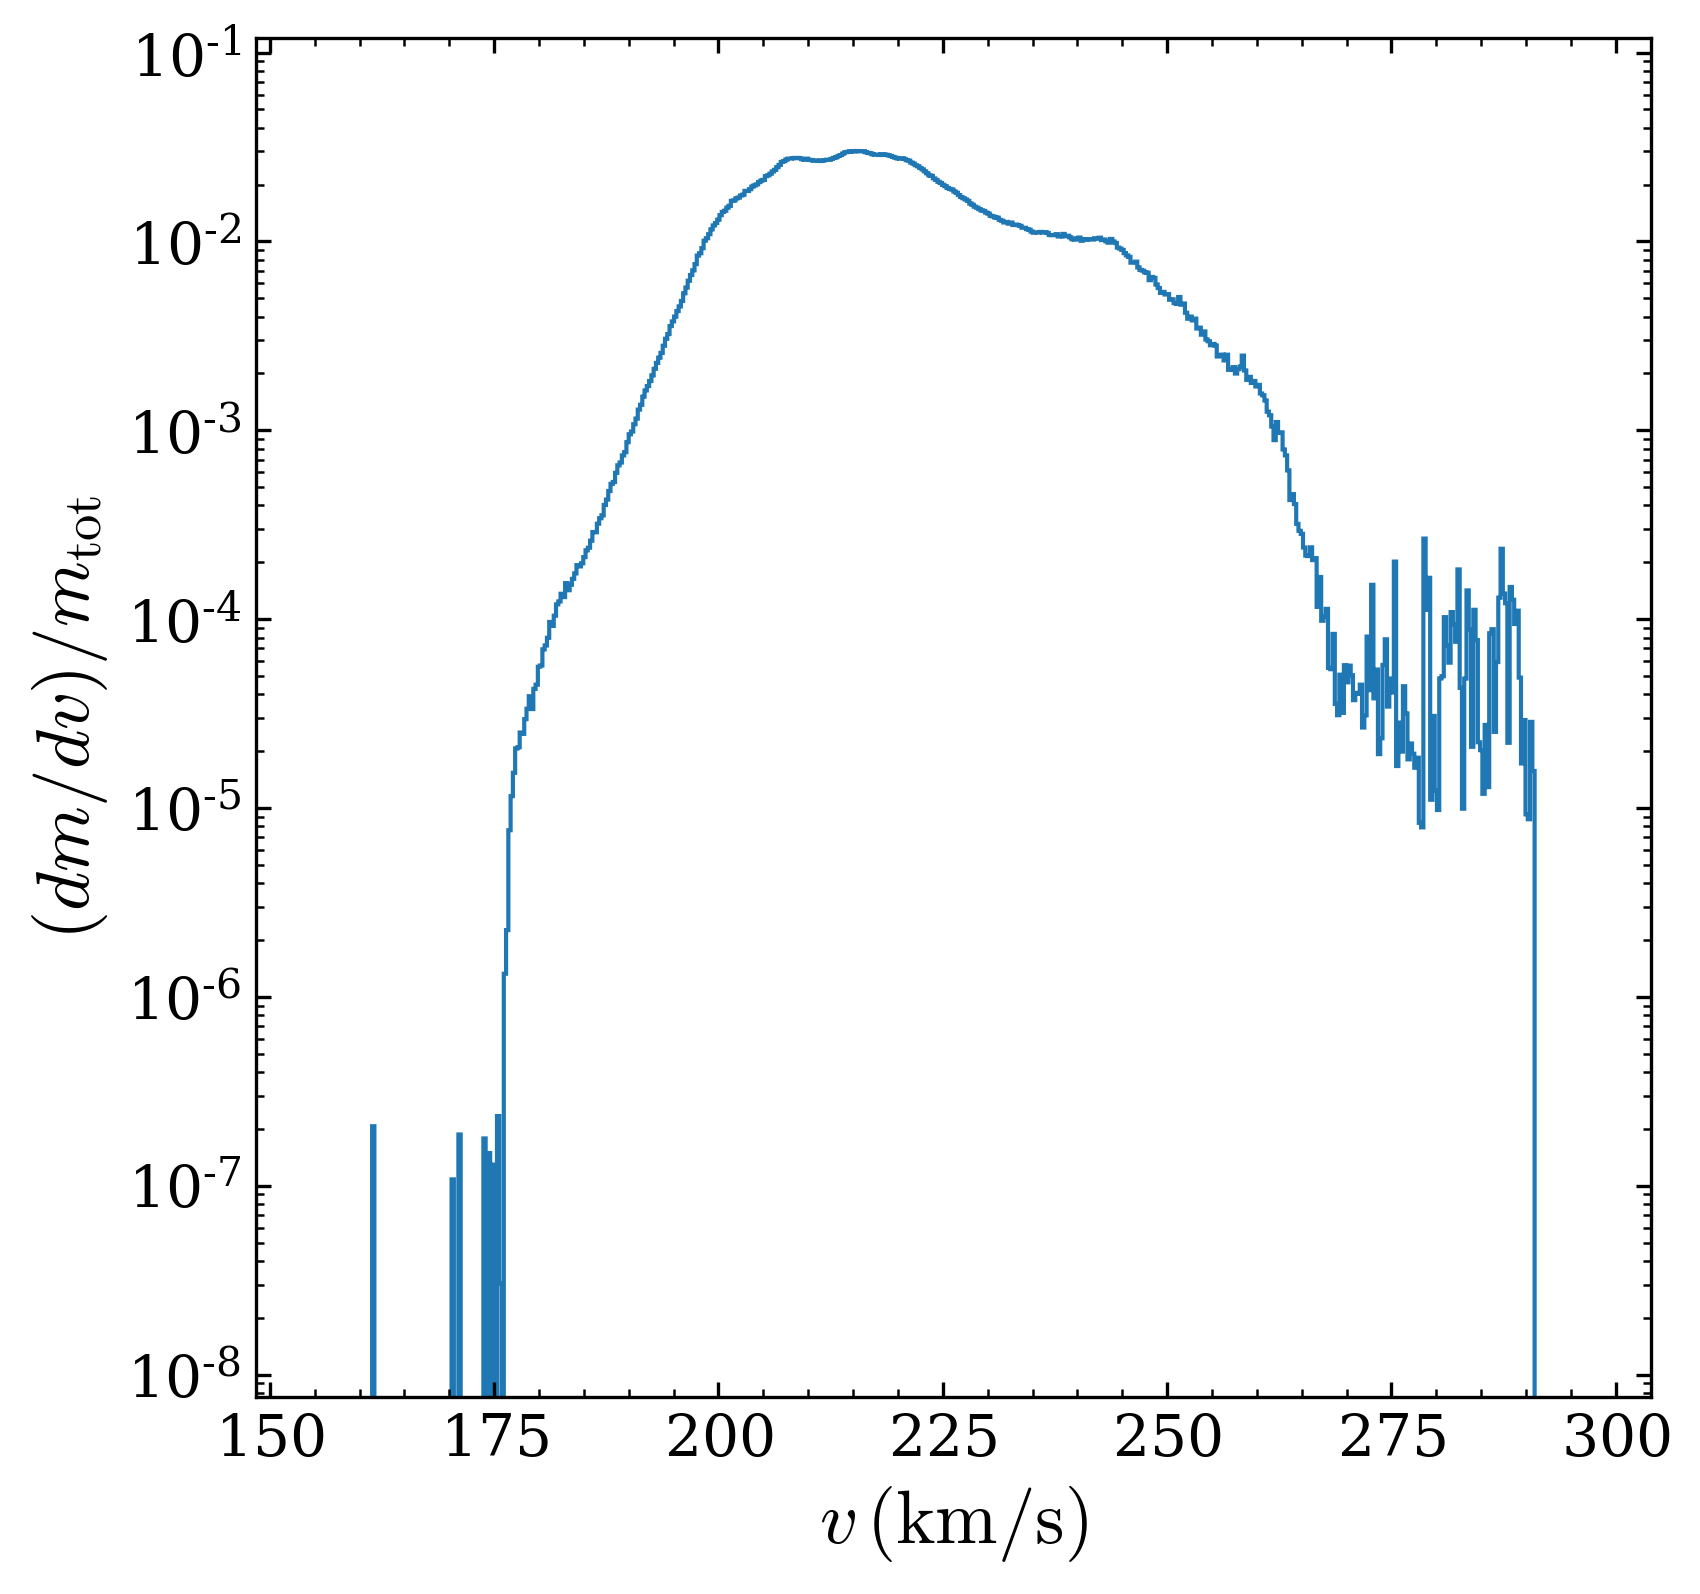

In [110]:
# Speed PDF
v = f['PartType0/Velocities'][()]
m = f['PartType0/Masses'][()]
speed = np.sqrt(v[:,0]**2 + v[:,1]**2 + v[:,2]**2)
plt.hist(speed, bins=512, density=True, histtype='step', weights=m, log=True)
plt.xlabel('$v\, \mathrm{(km/s)}$')
plt.ylabel('$(dm/dv)/m_\mathrm{tot}$')
# plt.title('Speed PDF')
plt.show()

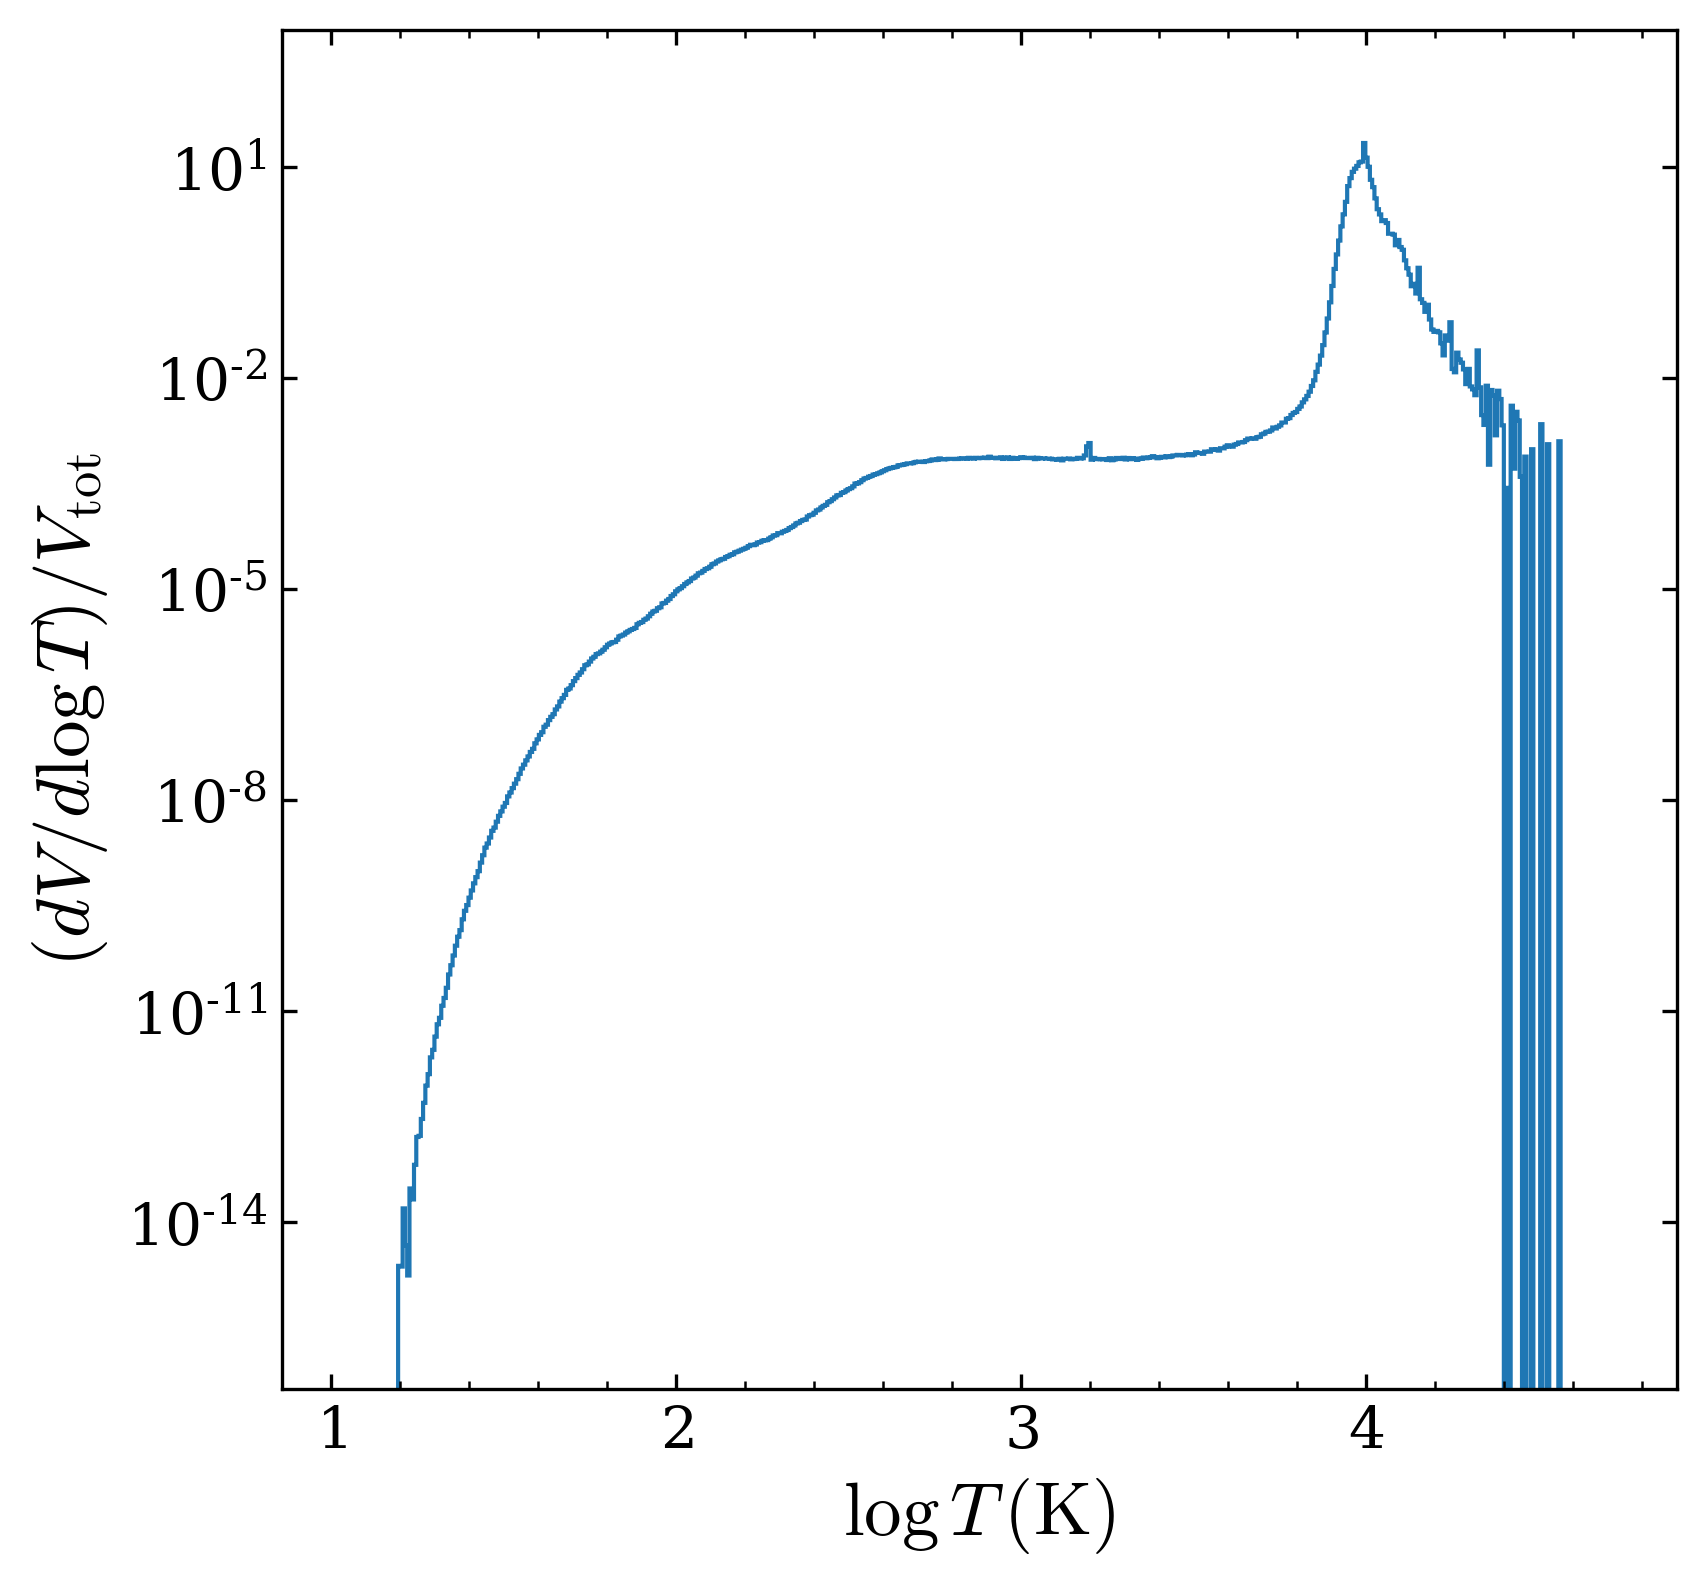

In [19]:
# Temperature PDF # Volume weighted: high-T stands out
XH = 0.76
mp = 1.67e-24
gamma = 5/3
kb = 1.38e-16
mu = 4/(1 + 3*XH + 4*XH*xe) * mp
T = (gamma - 1)*u/kb * 10**10 * mu
V = mass/rho
plt.hist(np.log10(T), bins=512, density=True, histtype='step', weights=V, log=True)
plt.xlabel('$\log{T} \, \mathrm{(K)}$')
plt.ylabel('$(dV/d\log{T})/V_\mathrm{tot}$')
# plt.title('Temperature PDF')
plt.show()

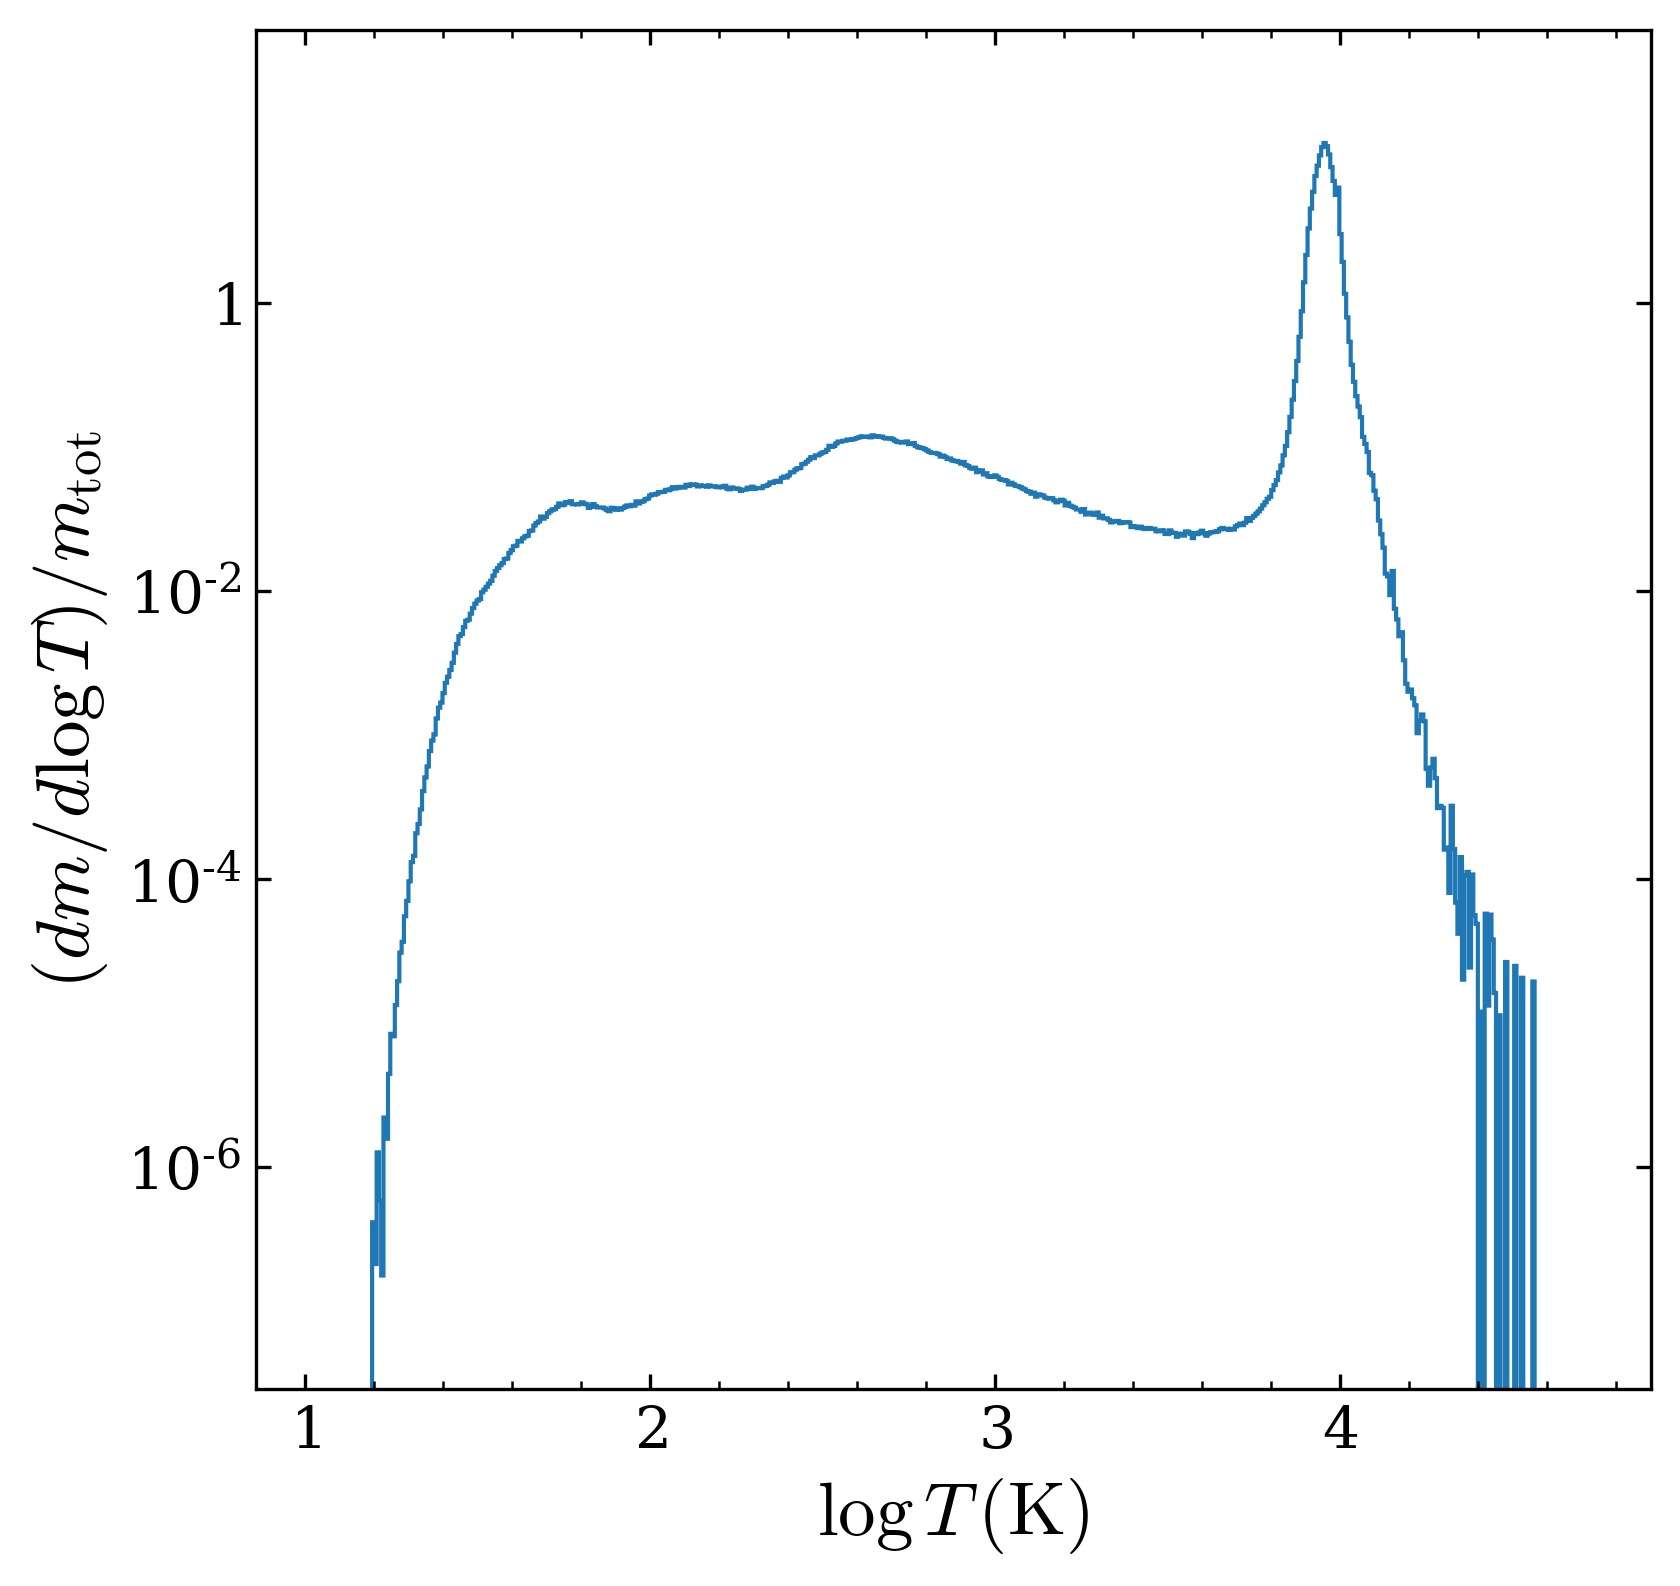

In [20]:
# Temperature PDF # Mass weighted: low-T stands out
plt.hist(np.log10(T), bins=512, density=True, histtype='step', weights=mass, log=True)
plt.xlabel('$\log{T} \, \mathrm{(K)}$')
plt.ylabel('$(dm/d\log{T})/m_\mathrm{tot}$')
# plt.title('Temperature PDF')
plt.show()

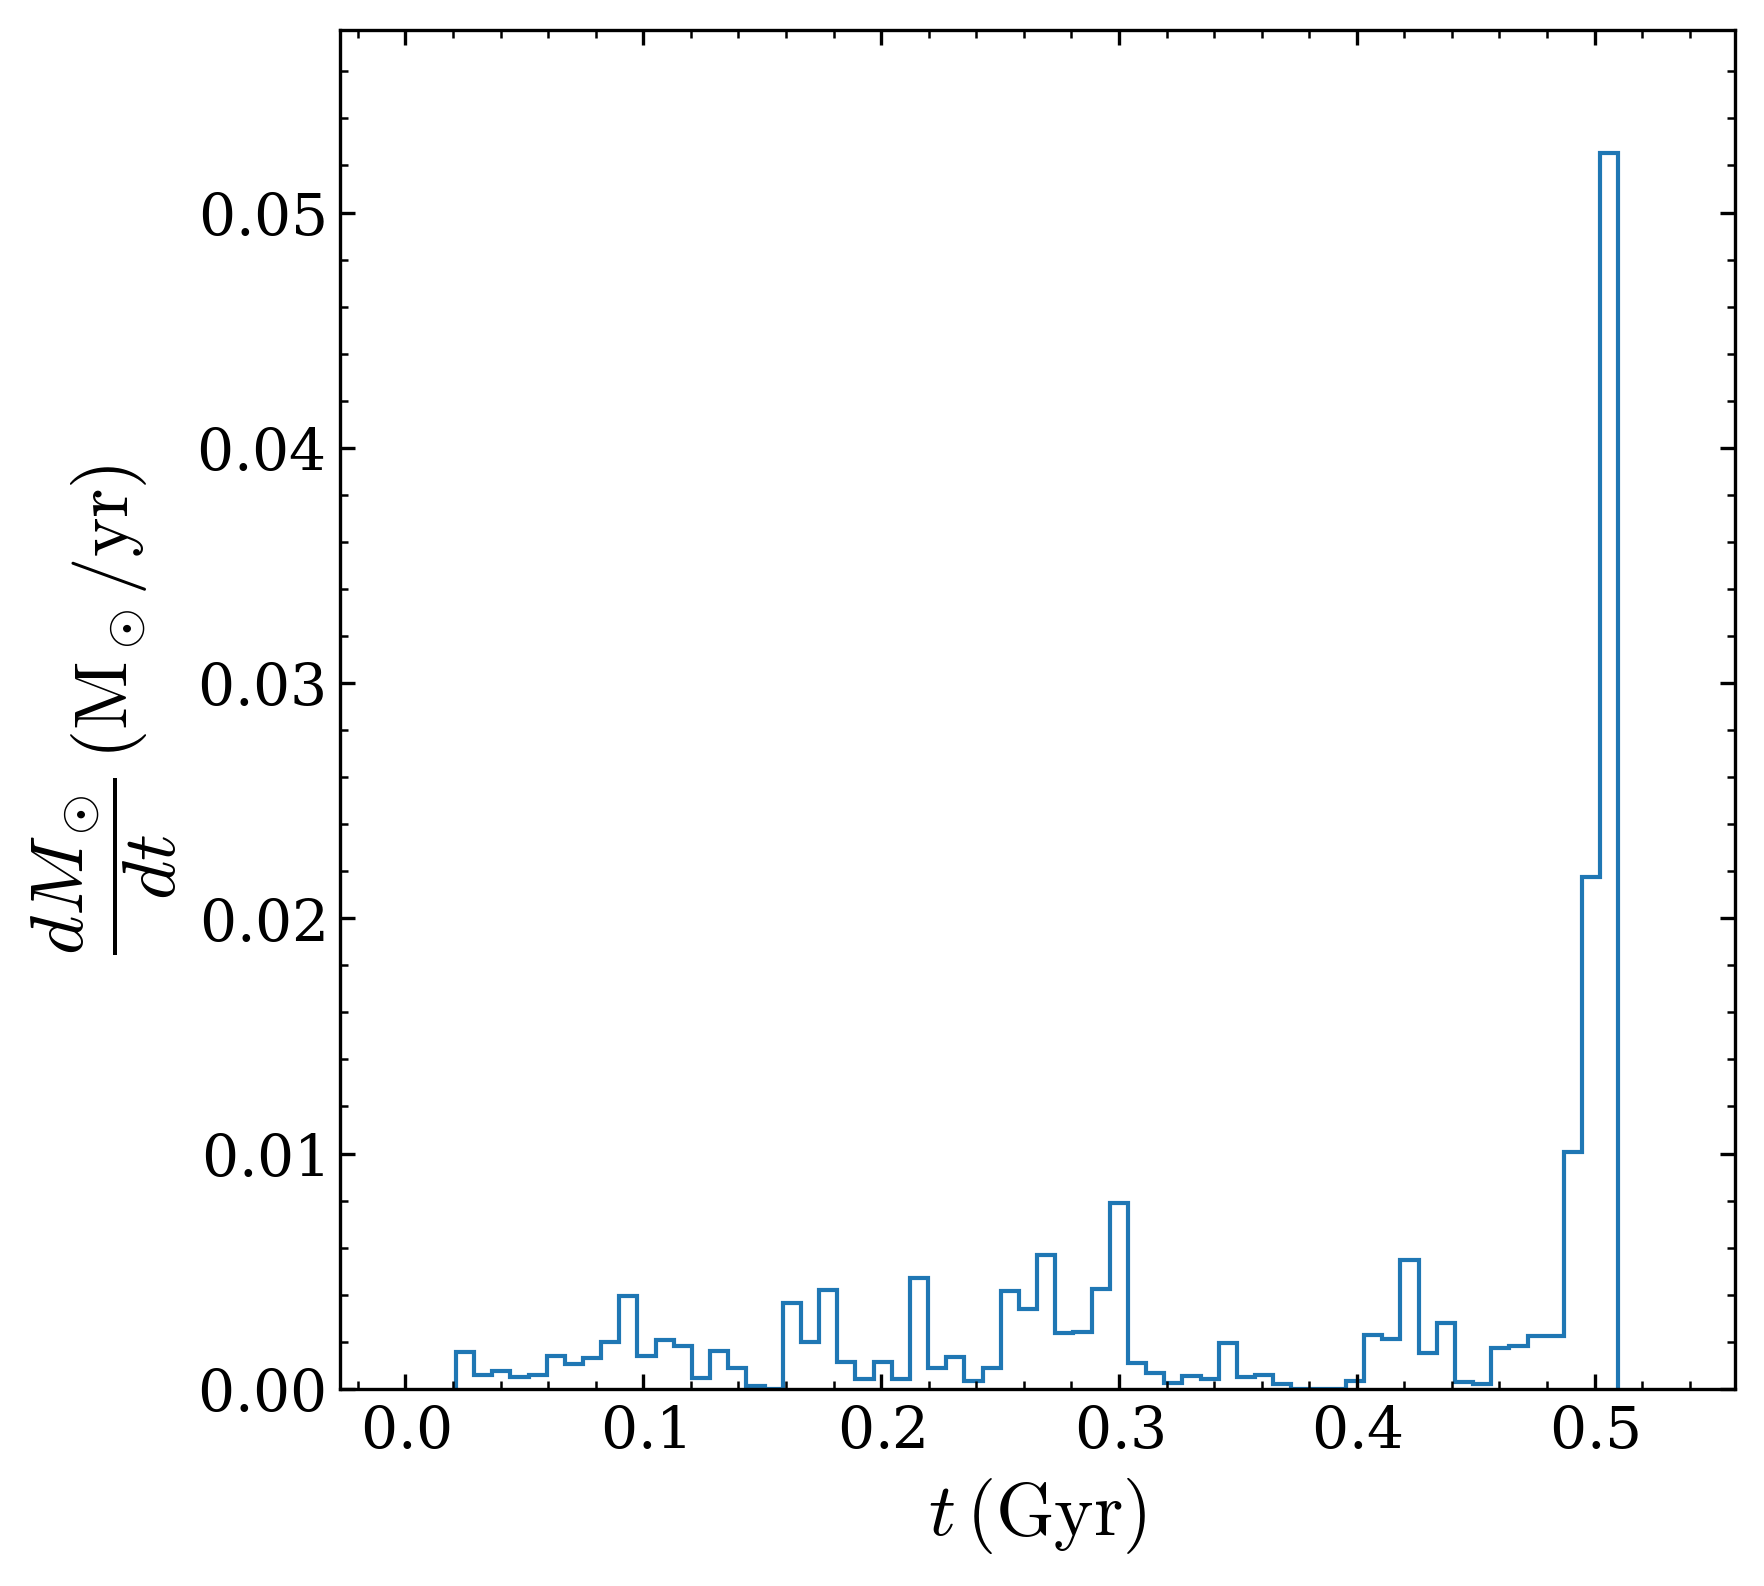

In [36]:
# Star formation history
sft = f['PartType4/GFM_StellarFormationTime'][()]
initial_mass = f['PartType4/GFM_InitialMass'][()]
bin_number = 64
bin_size = (np.max(sft) - np.min(sft)) / bin_number
plt.hist(sft, bins=bin_number, histtype='step', weights=initial_mass/bin_size*10)
plt.xlabel('$t \, \mathrm{(Gyr)}$')
plt.ylabel('$\dfrac{dM_\odot}{dt} \, \mathrm{(M_\odot/yr)}$')
# plt.title('Star Formation History')
plt.show()